# Import necessary packages

In [39]:
# Visualization
import matplotlib.pyplot as plt
from Sort import sort_for_plotting

# Data Manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.power as smp
from scipy.stats import pearsonr, jarque_bera, spearmanr, f_oneway, ttest_ind
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

# Fitting a model
from Artificial_Neural_Network import ANN
from Decision_Tree_Regression import Decision_Tree_Regression
from Random_Forest_Regression import Random_Forest_Regression
from Regression import Regression
from Spline_Regression import Spline_Regression
from satisfaction_score_data_generator import generate_dataset_with_sensor_readings_and_satisfaction_scores
from tqdm import tnrange, tqdm_notebook

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as pylab

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (12, 10),
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'xx-large',
          'ytick.labelsize': 'xx-large'}
pylab.rcParams.update(params)


# Data Analysis

### Data Generation

In order to generate the Synthetic Data for the analasys 
    
1. Indicate the number od samples to generate 
2. Choose type of a wavelet used for smoothing generated fucntion (i.e. db2, db4, db6, db8...etc.)
3. Indicate a value of standard deviation of the gausian noise added to the generated data


In [80]:
# Generate dataset with the scores and reading using satisfaction_score_data_generator.py
sample_size = 500
signal_to_noise_ratio = 2
wavelet = 'db8'

satisfaction_vs_sensors, satisfaction_vs_sensors_null = generate_dataset_with_sensor_readings_and_satisfaction_scores(sample_size,
                                                                                        signal_to_noise_ratio,
                                                                                        wavelet)

## Display summary statistics

In [81]:
satisfaction_vs_sensors.describe()

,sensor_temperature,sensor_humidity,sensor_heat_index,sensor_air,sensor_light,sensor_noise,comfort_score_temperature,comfort_score_humidity,comfort_score_heat_index,comfort_score_air,comfort_score_light,comfort_score_noise
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,23.340786,53.444107,23.654655,1323.537720,803.247009,51.968204,0.238119,0.527963,0.214600,0.275418,0.426316,0.498534
std,4.929715,19.288603,6.204647,584.869019,411.567352,12.518672,0.244773,0.244507,0.239195,0.294309,0.271152,0.281733
min,15.002381,20.027821,13.467579,301.089691,51.476444,30.022932,0.001254,0.006420,0.000538,0.000582,0.003701,0.002630
25%,18.902449,36.662633,18.248241,825.129044,464.464157,40.937960,0.018587,0.352501,0.018587,0.018587,0.170516,0.272486
50%,23.177105,52.652323,23.089198,1322.598206,814.413483,52.216478,0.145360,0.567981,0.114810,0.125916,0.449436,0.567204
75%,27.629971,70.981400,28.453697,1816.290863,1162.617462,63.059848,0.398365,0.736304,0.344260,0.519794,0.643381,0.742315
max,31.993423,84.762955,39.855793,2298.331299,1492.526001,74.852028,0.903252,0.930571,0.906281,0.929522,0.912051,0.901734


### Plot the correlation matrix

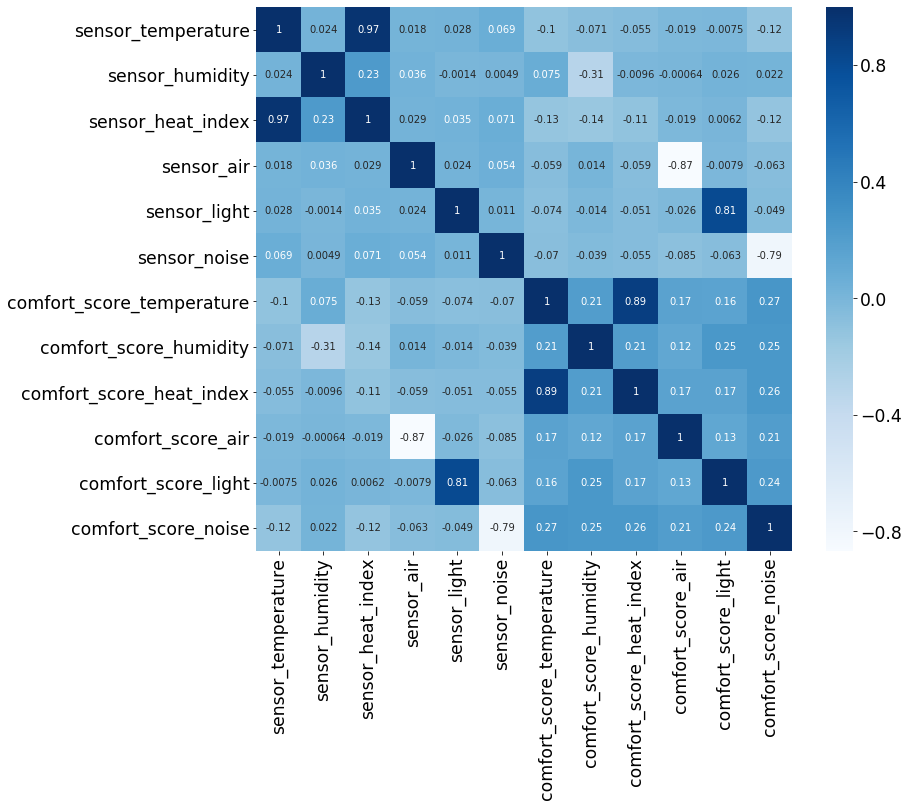

In [82]:
plt.figure(figsize=(12, 10))
sns.heatmap(satisfaction_vs_sensors.corr(), cmap='Blues', annot=True)
plt.show()

### Data distribution plots

Generated data distribution is visualised by using a boxplot and ploting a univariate distribution of observations.

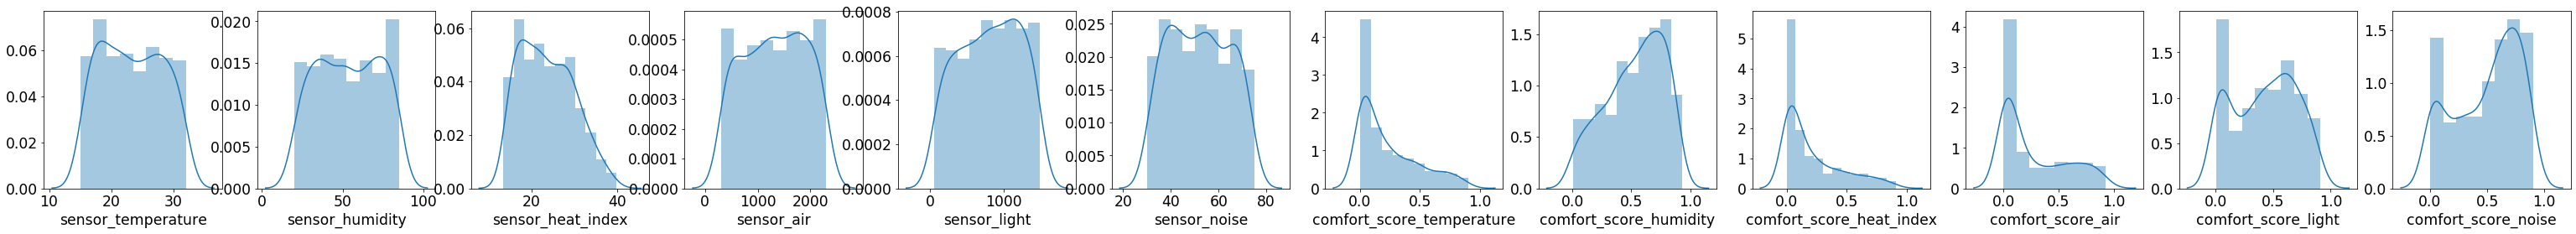

In [83]:
no_of_columns = np.shape(satisfaction_vs_sensors)[1]
measurements = satisfaction_vs_sensors.columns.values

plt.figure(figsize=(4.5*no_of_columns,5*no_of_columns))
for i in range(0,len(measurements)):
    plt.subplot(no_of_columns + 1, no_of_columns, i + 1)
    sns.distplot(satisfaction_vs_sensors[measurements[i]],kde=True)     

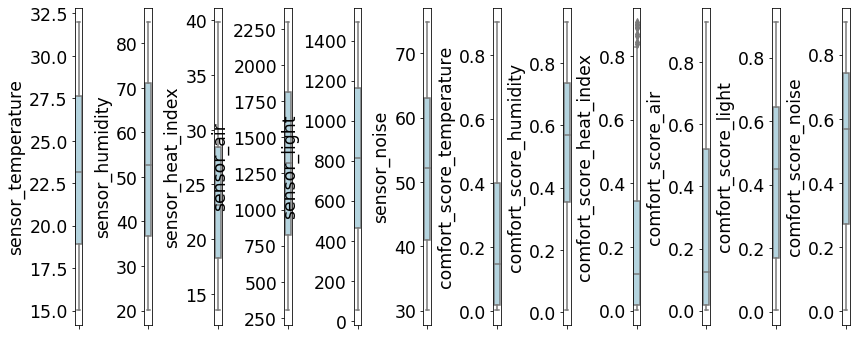

In [84]:
plt.figure(figsize=(no_of_columns,5*no_of_columns))
for i in range(0,len(measurements)):
    plt.subplot(no_of_columns + 1, no_of_columns, i + 1)
    sns.boxplot(satisfaction_vs_sensors[measurements[i]],color='lightblue',orient='v')
    plt.tight_layout()

### Divide the dataset into predictors and outcome

In orther to perform predicitons and further analysis, a measurement of interest has to be extracted from the generated dataset and divided into predictors (independent variable X) and outcome (dependent variable y).

The name of the measurement/score of interest can be specified by assigning a string value to the variable ***measurement_name*** from: 
    * temperature
    * humidity
    * heat_index
    * air
    * light
    * noise


In [251]:
# Specify the name of the measurement/score of interest
# Choose from: temperature, humidity, heat_index, air, light, noise

measurement_name = 'heat_index'
sensor_name = f'sensor_{measurement_name}'
score_name = f'comfort_score_{measurement_name}'

# Divide the dataset into predictors and outcome

X = satisfaction_vs_sensors[[sensor_name]]
y = satisfaction_vs_sensors[[score_name]]

### Visualise the variables

In order to visualise the data correctly by plotting the result of the prediction model or to plot the original data a funtion **Function sort_for_plotting** is used to sort the values before plotting

In [252]:
def sort_for_plotting(X, y):
    data_set = np.column_stack((X, y))
    test_set_sorted = data_set[data_set[:, 0].argsort()]
    X_sorted = test_set_sorted[:, 0]
    y_sorted = test_set_sorted[:, 1]

    return X_sorted, y_sorted

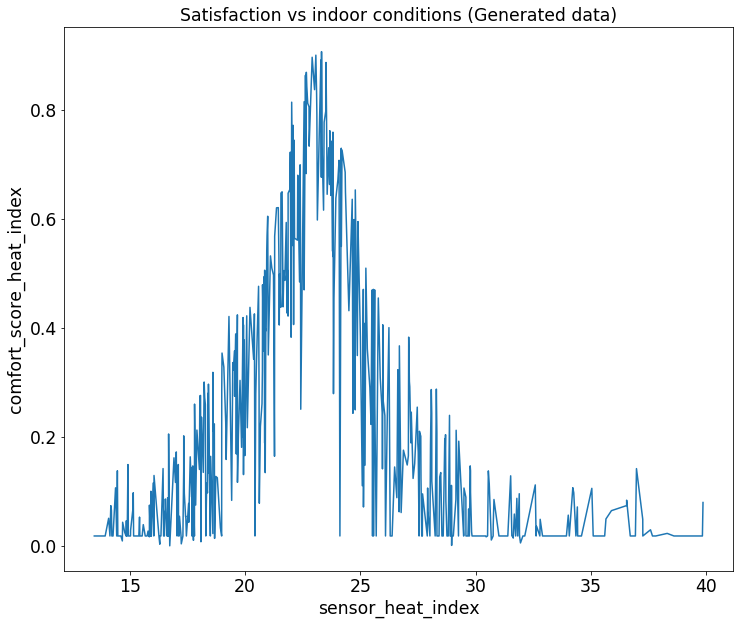

In [253]:
# Plot the original data
X_sorted, y_sorted = sort_for_plotting(X, y)

plt.figure(figsize=(12, 10))
plt.plot(X_sorted, y_sorted)
plt.xlabel(f"{sensor_name}")
plt.ylabel(f"{score_name}")
plt.title(f'Satisfaction vs indoor conditions (Generated data)')
plt.show()

### Jarque-Bera Test

Data is checked for normal distribution. If a variable doesn't have a normal distrubution, a logarithmic transformation is applied and tested.

H0: Data is normally distributed

H1: Skewness and kurtosis doesn't match a normal distribution

H0 is rejected when p-value < 0.05

Jarque-Bera Test for X: statistics = 23.56310003215036; p-value = 7.644302062570496e-06
Jarque-Bera Test for y: statistics = 119.02579316797745; p-value = 0.0
Jarque-Bera Test for X_log: statistics = 22.03253947673274; p-value = 1.6432167055380198e-05
Jarque-Bera Test for y_log: statistics = 23.501283987739136; p-value = 7.884261554513827e-06


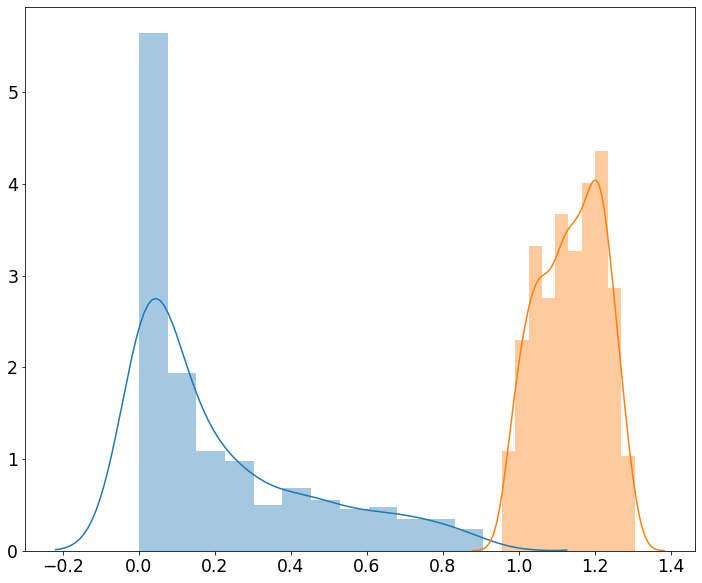

In [254]:
statistics_jb_X, p_value_jb_X = jarque_bera(X)
statistics_jb_y, p_value_jb_y = jarque_bera(y)

# Plot variable to examine its distribution
sns.distplot(y) 

# If the variable doesn't have a normal distribution check if it has log-normal distribution
X_log = np.log(X)
y_log = np.log(X_log)

statistics_jb_X_log, p_value_jb_X_log = jarque_bera(X_log)
statistics_jb_y_log, p_value_jb_y_log = jarque_bera(y_log) 

# Plot a transformed variable to examine its distribution
sns.distplot(y_log) 

print(f'Jarque-Bera Test for X: statistics = {statistics_jb_X}; p-value = {p_value_jb_X}')
print(f'Jarque-Bera Test for y: statistics = {statistics_jb_y}; p-value = {p_value_jb_y}')

print(f'Jarque-Bera Test for X_log: statistics = {statistics_jb_X_log}; p-value = {p_value_jb_X_log}')
print(f'Jarque-Bera Test for y_log: statistics = {statistics_jb_y_log}; p-value = {p_value_jb_y_log}')

### Spearman and Pearson test for correlation

Pearson correlation coefficient assumes a normal distribution. When a variable is not normally distributed use Spearman's rank correlation.

H0: There is no correlation

H1: Correlation coefficient is statistically significant

In [255]:
rho, p_value_spearman = spearmanr(X, y)
r, p_value_pearson = pearsonr(X.iloc[:, 0], y.iloc[:, 0])

print(f'Correlation Spearman = {rho}, p-value = {p_value_spearman}')
print(f'Correlation Pearson = {r}, p-value = {p_value_pearson}')

Correlation Spearman = -0.07188758801504412, p-value = 0.10838165874661135
Correlation Pearson = -0.10685482800651473, p-value = 0.016838595470612436


### Statistical power for regression 

Power is genarlly estimating a probablity that the regression finding is statistically significant.
For instance, having 90% power means that 90% of samples collected from the same population will demonstrate a significant relationship (H0 is rejected).

Power can be determined by calculating L value, which is a non-centrality parameter and reading the value from the table below for a given number of predictors $k$.

![image.png](attachment:image.png)

Cohen, J. (2013). Statistical power analysis for the behavioral sciences. Routledge.

In [256]:
# Set parameters to perform the test
R2_regression = 0.6
number_of_predictors_degrees = 3
sample_size = 10

# Effect size can be calculated using the R2 statistic 
cohen_effect_size = R2_regression / (1 - R2_regression)
# squared_correlation_coefficient_effect_size = r**2

L_value_non_centrality_parameter = cohen_effect_size * (sample_size - number_of_predictors_degrees - 1)

# Read the power from the table based on non centrality parameter
L_value_non_centrality_parameter

8.999999999999998

In [257]:
# Set parameters to perform the sample size estimation using L-value
R2_regression = 0.4
number_of_predictors_degrees = 3

# Read from the tables e.g. for 80% power and 3 predictors the value is:
L_value = 10.9

# Effect size can be calculated using the R2 statistic 
cohen_effect_size = R2_regression / (1 - R2_regression)

estimated_sample_size = (L_value / cohen_effect_size) + number_of_predictors_degrees + 1
estimated_sample_size

20.349999999999998

### Size of a sample needed
One-sample t-test is another method to determine the sample size given the needed test power, significance level and the effect size (or to determine the power).

In [258]:
# Set parameters to perform the test, put "None" by the parameter that is needed to be calculated
R2_regression = 0.4
effect_size = R2_regression / (1 - R2_regression) #ignore
number_of_observations = None
significance = 0.05
test_power = 0.9

power_test = smp.TTestPower().solve_power(effect_size=effect_size, nobs=number_of_observations, alpha=significance,
                                    power = test_power, alternative='larger')

print(f'Sample Size: {power_test}') 
# all the results give a very small sample 
# Maybe square of the Pearson correlation coefficient would be better as an effect size - size of a sample is huge
#how extreme the correlation has to be to reject the null model - how many false positive we allow
# effect size - shifting from 0 how easy is to tell apart null form alternative
#null model slope is 0 - alternative slope is e.g. 1
# use bootstrap for power analysis

Sample Size: 20.699143325387332


In [259]:
effect_size

0.6666666666666667

### Power plots

Plots presented below allow see how the power changes with number of observations and effect size 

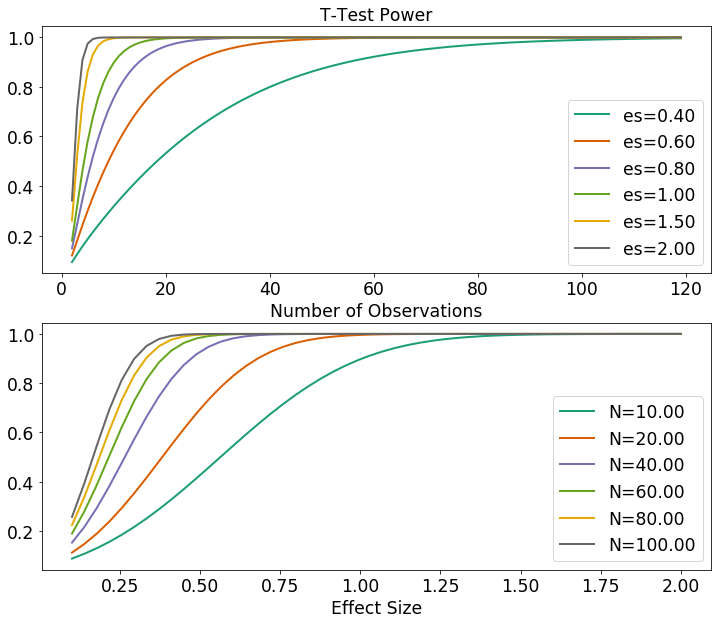

In [260]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2,1,1)
fig = smp.TTestPower().plot_power(dep_var='nobs',
                                  nobs= np.arange(2, 120),
                                  effect_size=np.array([0.4, 0.6, 0.8, 1, 1.5, 2]),
                                  alternative='larger',
                                  ax=ax, title='T-Test Power')
ax = fig.add_subplot(2,1,2)
fig = smp.TTestPower().plot_power(dep_var='es',
                                  nobs=np.array([10, 20, 40, 60, 80, 100]),
                                  effect_size=np.linspace(0.1, 2),
                                  alternative='larger',
                                  ax=ax, title='')

### Ordinary Least Squares (OLS) model

Summary statistics for the OLS displayes the R-squared that shows how well the data fits the model.

F-statistic that measures the significance of the fit and T-statistics measures the significance of the estimated coefficients.

F-statistic:

    H0: All of the regression coefficients are equal to zero

    H1: Model has good predictive capability

T-statistics:

    H0: Variable is not signoificant to the model

    H1: Significant relationship between the response and explanatory variables


In terms of the model residual distribution, Jarque-Bera Test for the normality


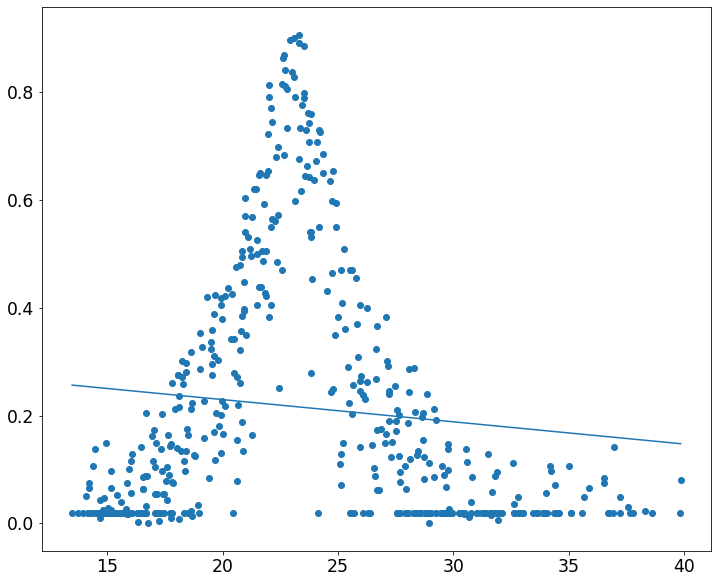

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     comfort_score_heat_index   R-squared:                       0.011
Model:                                  OLS   Adj. R-squared:                  0.009
Method:                       Least Squares   F-statistic:                     5.752
Date:                      Wed, 13 Nov 2019   Prob (F-statistic):             0.0168
Time:                              11:45:34   Log-Likelihood:                 9.1406
No. Observations:                       500   AIC:                            -14.28
Df Residuals:                           498   BIC:                            -5.852
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3120      0.042      7.429      0.000       0.230       0.395
x1            -0.0041      0.002     -2.398      0.017      -0.007      -0.001
==============================================================================
Omnibus:                       79.957   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.698
Skew:                           1.171   Prob(JB):                     4.57e-26
Kurtosis:                       3.342   Cond. No.                         96.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
degree = 1

# Perform polynomial transformation
polynomial_features = PolynomialFeatures(degree=degree)
X_polynomial = polynomial_features.fit_transform(X)

# Fit the model
model = sm.OLS(y, X_polynomial).fit()
y_predicted = model.predict(X_polynomial)

slope, intercept = np.polyfit(np.log(X.iloc[:, 0]), np.log(y.iloc[:, 0]), 1)

# Plot the prediction
plt.scatter(X,y)
X_sorted, y_sorted_p = sort_for_plotting(X, y_predicted)
plt.plot(X_sorted, y_sorted_p)
plt.show()

# Show summary statistics
model.summary()

### Test for Heteroskedasticity

H0: Homoskedasticity
    
H1: Heteroskedasticity

In [262]:
bp_test = het_breuschpagan(model.resid, X_polynomial)
white_test = het_white(model.resid,  model.model.exog)

labels = ['Lagrange Multiplier Statistic', 'Lagrange Multiplier-Test p-value', 'F-Statistic', 'F-Test p-value']

print(dict(zip(labels, bp_test)))
print(dict(zip(labels, white_test)))

{'Lagrange Multiplier Statistic': 6.249866017315641, 'Lagrange Multiplier-Test p-value': 0.012420270083554393, 'F-Statistic': 6.303660621856857, 'F-Test p-value': 0.012364633946869126}
{'Lagrange Multiplier Statistic': 44.735235335536636, 'Lagrange Multiplier-Test p-value': 1.9313770814124682e-10, 'F-Statistic': 24.41811192894322, 'F-Test p-value': 7.665980002967174e-11}


## ANOVA Test

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

H0: $\mu_1 = \mu_2$

H1: $\mu_1 \neq \mu_2$

In [263]:
# F_statistic, p_value_anova = f_oneway(X, y)

# print(f'ANOVA F-statistic = {F_statistic}, p-value = {p_value_anova}')

# Compute ANOVA
# anova_results = pg.anova(dv=score_name, between=sensor_name, data=satisfaction_vs_sensors_sorted)

# pg.print_table(anova_results)

### T-test for the means of two independent samples of scores.

H0: $\mu_1 = \mu_2$

H1: $\mu_1 \neq \mu_2$


In [264]:
# t_statistics, p_value_t = ttest_ind(X, y)


# Model Testing

All the methods are tested over various parameters in order to find the best set.

## Random Forest

This method takes as parameters maximum depth of the tree: **max_depth** and number of trees in the forest: **n_estimators**

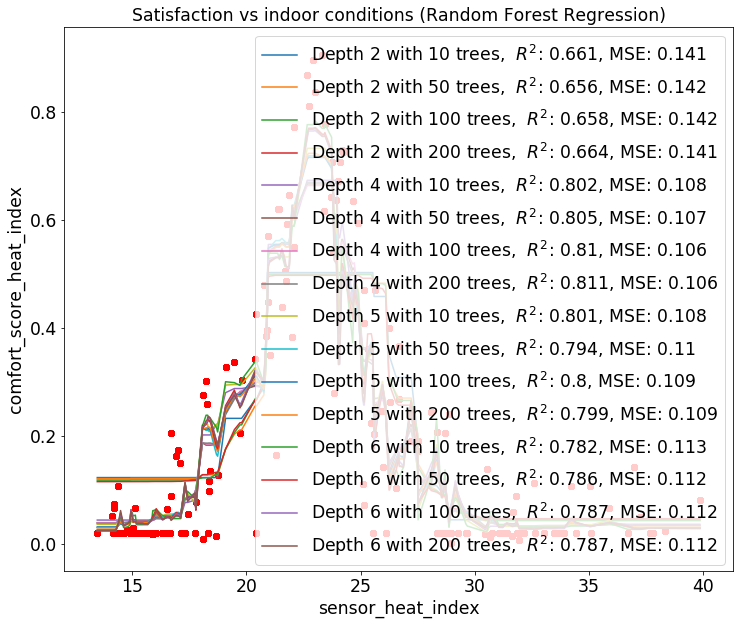

In [265]:
max_depth = [2, 4, 5, 6]
n_estimators = [10, 50, 100, 200]
Results_Random_Forest_list = []

plt.figure(figsize=(12, 10))

for depth in tqdm_notebook(max_depth):
    for estimator in n_estimators:
        R2_random_forest, MSE_random_forest = Random_Forest_Regression(X, y, depth, estimator, 'plot', sensor_name,
                                                                       score_name)
        Results_Random_Forest_list.append([depth, estimator, R2_random_forest, MSE_random_forest])

#### Display the results for Random Forest
Results of the testing are displayed in the table below, sorted accoding to R2.

In [266]:
Results_Random_Forest = pd.DataFrame(Results_Random_Forest_list, columns=['max_depth', 'n_estimators',
                                                                     'R2_random_forest', 'MSE_random_forest'])
Results_Random_Forest.sort_values(['R2_random_forest'], ascending = False)

,max_depth,n_estimators,R2_random_forest,MSE_random_forest
7,4,200,0.810740,0.105563
6,4,100,0.809865,0.105807
5,4,50,0.804549,0.107276
4,4,10,0.802296,0.107892
8,5,10,0.801151,0.108204
10,5,100,0.799889,0.108547
11,5,200,0.798893,0.108817
9,5,50,0.793589,0.110243
14,6,100,0.786723,0.112061
15,6,200,0.786709,0.112065


## Boosted Decision Tree Regression

This method takes as parameters maximum depth of the tree: **max_depth** and maximum number of estimators at which boosting is terminated: **n_estimators**

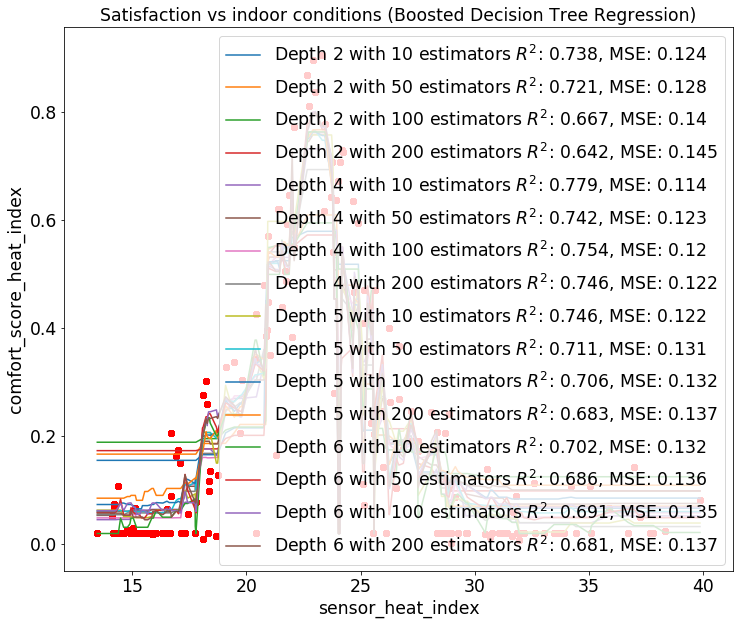

In [267]:
max_depth = [2, 4, 5, 6]
n_estimators = [10, 50, 100, 200]
Results_Decision_Tree_list = []

plt.figure(figsize=(12, 10))
for depth in tqdm_notebook(max_depth):
    for estimator in n_estimators:
        R2_decision_tree, MSE_decision_tree = Decision_Tree_Regression(X, y, depth, estimator, 'plot', sensor_name,
                                                                       score_name)
        Results_Decision_Tree_list.append([depth, estimator, R2_decision_tree, MSE_decision_tree])

#### Display the results for Boosted Decision Tree

In [268]:
Results_Decision_Tree = pd.DataFrame(Results_Decision_Tree_list, columns=['max_depth', 'n_estimators',
                                                                          'R2_decision_tree', 'MSE_decision_tree'])
Results_Decision_Tree.sort_values(['R2_decision_tree'], ascending=False)

,max_depth,n_estimators,R2_decision_tree,MSE_decision_tree
4,4,10,0.779491,0.113945
6,4,100,0.753881,0.120380
7,4,200,0.746211,0.122242
8,5,10,0.746007,0.122291
5,4,50,0.741716,0.123320
0,2,10,0.738113,0.124177
1,2,50,0.720825,0.128210
9,5,50,0.710554,0.130547
10,5,100,0.705631,0.131653
12,6,10,0.702260,0.132404


## Artificial Neural Networks

This method takes as parameters number of nodes (neurons): **number_of_nodes** and layers: **number_of_layers** in the Neural Network architecture. In order to reduce overfitting dropout and regularization are applied. Variables **dropout_rate** and **regularization_penalty** introduce the necessary modifications. Lastly, the number of training iterations is determined by parameter: **number_of_epochs**.

Train on 333 samples, validate on 167 samples
Epoch 1/1000
333/333 [==============================] - ETA: 1s - loss: 0.3198 - mean_squared_error: 0.26 - 0s 583us/step - loss: 0.3222 - mean_squared_error: 0.2701 - val_loss: 0.1978 - val_mean_squared_error: 0.1473
Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.2190 - mean_squared_error: 0.16 - 0s 57us/step - loss: 0.1792 - mean_squared_error: 0.1297 - val_loss: 0.1246 - val_mean_squared_error: 0.0764
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.1580 - mean_squared_error: 0.10 - 0s 63us/step - loss: 0.1418 - mean_squared_error: 0.0946 - val_loss: 0.1130 - val_mean_squared_error: 0.0671
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.1199 - mean_squared_error: 0.07 - 0s 60us/step - loss: 0.1282 - mean_squared_error: 0.0833 - val_loss: 0.0972 - val_mean_squared_error: 0.0534
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.1049 - mean

Epoch 76/1000
333/333 [==============================] - ETA: 0s - loss: 0.0251 - mean_squared_error: 0.01 - 0s 58us/step - loss: 0.0285 - mean_squared_error: 0.0205 - val_loss: 0.0260 - val_mean_squared_error: 0.0182
Epoch 77/1000
333/333 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.00 - 0s 57us/step - loss: 0.0283 - mean_squared_error: 0.0205 - val_loss: 0.0262 - val_mean_squared_error: 0.0184
Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0458 - mean_squared_error: 0.03 - 0s 60us/step - loss: 0.0294 - mean_squared_error: 0.0217 - val_loss: 0.0257 - val_mean_squared_error: 0.0181
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0300 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0297 - mean_squared_error: 0.0221 - val_loss: 0.0257 - val_mean_squared_error: 0.0182
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0306 - mean_squared_error: 0.02 - 0s 66us/step - loss

Epoch 114/1000
333/333 [==============================] - ETA: 0s - loss: 0.0366 - mean_squared_error: 0.03 - 0s 57us/step - loss: 0.0259 - mean_squared_error: 0.0213 - val_loss: 0.0226 - val_mean_squared_error: 0.0180
Epoch 115/1000
333/333 [==============================] - ETA: 0s - loss: 0.0183 - mean_squared_error: 0.01 - 0s 56us/step - loss: 0.0252 - mean_squared_error: 0.0206 - val_loss: 0.0226 - val_mean_squared_error: 0.0180
Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0245 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0251 - mean_squared_error: 0.0206 - val_loss: 0.0226 - val_mean_squared_error: 0.0180
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0253 - mean_squared_error: 0.0208 - val_loss: 0.0225 - val_mean_squared_error: 0.0180
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0274 - mean_squared_error: 0.02 - 0s 57us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0237 - mean_squared_error: 0.0212 - val_loss: 0.0206 - val_mean_squared_error: 0.0180
Epoch 189/1000
333/333 [==============================] - ETA: 0s - loss: 0.0264 - mean_squared_error: 0.02 - 0s 56us/step - loss: 0.0238 - mean_squared_error: 0.0212 - val_loss: 0.0211 - val_mean_squared_error: 0.0185
Epoch 190/1000
333/333 [==============================] - ETA: 0s - loss: 0.0149 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0234 - mean_squared_error: 0.0208 - val_loss: 0.0207 - val_mean_squared_error: 0.0182
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.03 - 0s 57us/step - loss: 0.0242 - mean_squared_error: 0.0216 - val_loss: 0.0207 - val_mean_squared_error: 0.0181
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.02 - 0s 58us/step - loss: 0.0231 -

333/333 [==============================] - ETA: 0s - loss: 0.0205 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0239 - mean_squared_error: 0.0218 - val_loss: 0.0201 - val_mean_squared_error: 0.0180
Epoch 263/1000
333/333 [==============================] - ETA: 0s - loss: 0.0192 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0235 - mean_squared_error: 0.0214 - val_loss: 0.0202 - val_mean_squared_error: 0.0181
Epoch 264/1000
333/333 [==============================] - ETA: 0s - loss: 0.0257 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0237 - mean_squared_error: 0.0216 - val_loss: 0.0202 - val_mean_squared_error: 0.0181
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0271 - mean_squared_error: 0.02 - 0s 59us/step - loss: 0.0226 - mean_squared_error: 0.0205 - val_loss: 0.0201 - val_mean_squared_error: 0.0180
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0208 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0221 -

333/333 [==============================] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.03 - 0s 60us/step - loss: 0.0236 - mean_squared_error: 0.0215 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 337/1000
333/333 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0227 - mean_squared_error: 0.0207 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 338/1000
333/333 [==============================] - ETA: 0s - loss: 0.0289 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0233 - mean_squared_error: 0.0213 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0287 - mean_squared_error: 0.02 - 0s 58us/step - loss: 0.0225 - mean_squared_error: 0.0206 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0223 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0224 -

333/333 [==============================] - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0223 - mean_squared_error: 0.0204 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 411/1000
333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0226 - mean_squared_error: 0.0206 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 412/1000
333/333 [==============================] - ETA: 0s - loss: 0.0235 - mean_squared_error: 0.02 - 0s 56us/step - loss: 0.0226 - mean_squared_error: 0.0206 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0228 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0226 - mean_squared_error: 0.0207 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.01 - 0s 54us/step - loss: 0.0227 -

333/333 [==============================] - ETA: 0s - loss: 0.0220 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0232 - mean_squared_error: 0.0212 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 485/1000
333/333 [==============================] - ETA: 0s - loss: 0.0209 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0230 - mean_squared_error: 0.0210 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 486/1000
333/333 [==============================] - ETA: 0s - loss: 0.0269 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0237 - mean_squared_error: 0.0217 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0227 - mean_squared_error: 0.0207 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0226 -

333/333 [==============================] - ETA: 0s - loss: 0.0222 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0227 - mean_squared_error: 0.0207 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 559/1000
333/333 [==============================] - ETA: 0s - loss: 0.0219 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0222 - mean_squared_error: 0.0203 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 560/1000
333/333 [==============================] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0228 - mean_squared_error: 0.0209 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0229 - mean_squared_error: 0.02 - 0s 59us/step - loss: 0.0229 - mean_squared_error: 0.0209 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0132 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0228 -

333/333 [==============================] - ETA: 0s - loss: 0.0308 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0237 - mean_squared_error: 0.0218 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 633/1000
333/333 [==============================] - ETA: 0s - loss: 0.0223 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0233 - mean_squared_error: 0.0213 - val_loss: 0.0202 - val_mean_squared_error: 0.0182
Epoch 634/1000
333/333 [==============================] - ETA: 0s - loss: 0.0276 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0221 - mean_squared_error: 0.0201 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0279 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0227 - mean_squared_error: 0.0208 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0168 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0228 -

333/333 [==============================] - ETA: 0s - loss: 0.0174 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0220 - mean_squared_error: 0.0200 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 707/1000
333/333 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0224 - mean_squared_error: 0.0205 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 708/1000
333/333 [==============================] - ETA: 0s - loss: 0.0236 - mean_squared_error: 0.02 - 0s 56us/step - loss: 0.0229 - mean_squared_error: 0.0209 - val_loss: 0.0202 - val_mean_squared_error: 0.0182
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0242 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0230 - mean_squared_error: 0.0210 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.03 - 0s 63us/step - loss: 0.0221 -

333/333 [==============================] - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0214 - mean_squared_error: 0.0195 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 781/1000
333/333 [==============================] - ETA: 0s - loss: 0.0262 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0227 - mean_squared_error: 0.0207 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 782/1000
333/333 [==============================] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.01 - 0s 58us/step - loss: 0.0226 - mean_squared_error: 0.0207 - val_loss: 0.0201 - val_mean_squared_error: 0.0182
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0193 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0226 - mean_squared_error: 0.0207 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.03 - 0s 57us/step - loss: 0.0234 -

333/333 [==============================] - ETA: 0s - loss: 0.0255 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0225 - mean_squared_error: 0.0206 - val_loss: 0.0202 - val_mean_squared_error: 0.0183
Epoch 855/1000
333/333 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.02 - 0s 59us/step - loss: 0.0224 - mean_squared_error: 0.0204 - val_loss: 0.0202 - val_mean_squared_error: 0.0183
Epoch 856/1000
333/333 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0217 - mean_squared_error: 0.0197 - val_loss: 0.0202 - val_mean_squared_error: 0.0183
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0288 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0224 - mean_squared_error: 0.0205 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0231 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0223 -

333/333 [==============================] - ETA: 0s - loss: 0.0164 - mean_squared_error: 0.01 - 0s 69us/step - loss: 0.0229 - mean_squared_error: 0.0210 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 929/1000
333/333 [==============================] - ETA: 0s - loss: 0.0160 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0230 - mean_squared_error: 0.0210 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 930/1000
333/333 [==============================] - ETA: 0s - loss: 0.0238 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0221 - mean_squared_error: 0.0202 - val_loss: 0.0201 - val_mean_squared_error: 0.0182
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0167 - mean_squared_error: 0.01 - 0s 56us/step - loss: 0.0220 - mean_squared_error: 0.0200 - val_loss: 0.0202 - val_mean_squared_error: 0.0182
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0159 - mean_squared_error: 0.01 - 0s 56us/step - loss: 0.0222 -

Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.0809 - mean_squared_error: 0.07 - 0s 63us/step - loss: 0.1248 - mean_squared_error: 0.1195 - val_loss: 0.0957 - val_mean_squared_error: 0.0905
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.1018 - mean_squared_error: 0.09 - 0s 66us/step - loss: 0.0944 - mean_squared_error: 0.0893 - val_loss: 0.0720 - val_mean_squared_error: 0.0669
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.0918 - mean_squared_error: 0.08 - 0s 75us/step - loss: 0.0772 - mean_squared_error: 0.0722 - val_loss: 0.0535 - val_mean_squared_error: 0.0484
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.0807 - mean_squared_error: 0.07 - 0s 72us/step - loss: 0.0592 - mean_squared_error: 0.0542 - val_loss: 0.0398 - val_mean_squared_error: 0.0348
Epoch 6/1000
333/333 [==============================] - ETA: 0s - loss: 0.0395 - mean_squared_error: 0.03 - 0s 63us/step - loss: 0.0

Epoch 40/1000
333/333 [==============================] - ETA: 0s - loss: 0.0368 - mean_squared_error: 0.03 - 0s 63us/step - loss: 0.0276 - mean_squared_error: 0.0236 - val_loss: 0.0240 - val_mean_squared_error: 0.0200
Epoch 41/1000
333/333 [==============================] - ETA: 0s - loss: 0.0313 - mean_squared_error: 0.02 - 0s 59us/step - loss: 0.0266 - mean_squared_error: 0.0226 - val_loss: 0.0240 - val_mean_squared_error: 0.0200
Epoch 42/1000
333/333 [==============================] - ETA: 0s - loss: 0.0314 - mean_squared_error: 0.02 - 0s 54us/step - loss: 0.0257 - mean_squared_error: 0.0217 - val_loss: 0.0238 - val_mean_squared_error: 0.0199
Epoch 43/1000
333/333 [==============================] - ETA: 0s - loss: 0.0222 - mean_squared_error: 0.01 - 0s 54us/step - loss: 0.0267 - mean_squared_error: 0.0228 - val_loss: 0.0238 - val_mean_squared_error: 0.0199
Epoch 44/1000
333/333 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 63us/step - loss

Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0247 - mean_squared_error: 0.02 - 0s 58us/step - loss: 0.0260 - mean_squared_error: 0.0227 - val_loss: 0.0233 - val_mean_squared_error: 0.0200
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0252 - mean_squared_error: 0.0219 - val_loss: 0.0236 - val_mean_squared_error: 0.0204
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0230 - mean_squared_error: 0.0197 - val_loss: 0.0237 - val_mean_squared_error: 0.0204
Epoch 81/1000
333/333 [==============================] - ETA: 0s - loss: 0.0272 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0252 - mean_squared_error: 0.0220 - val_loss: 0.0236 - val_mean_squared_error: 0.0203
Epoch 82/1000
333/333 [==============================] - ETA: 0s - loss: 0.0262 - mean_squared_error: 0.02 - 0s 56us/step - loss

Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0231 - mean_squared_error: 0.0204 - val_loss: 0.0229 - val_mean_squared_error: 0.0202
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0277 - mean_squared_error: 0.02 - 0s 58us/step - loss: 0.0235 - mean_squared_error: 0.0208 - val_loss: 0.0227 - val_mean_squared_error: 0.0200
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0239 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0231 - mean_squared_error: 0.0204 - val_loss: 0.0227 - val_mean_squared_error: 0.0200
Epoch 119/1000
333/333 [==============================] - ETA: 0s - loss: 0.0238 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0242 - mean_squared_error: 0.0215 - val_loss: 0.0227 - val_mean_squared_error: 0.0200
Epoch 120/1000
333/333 [==============================] - ETA: 0s - loss: 0.0252 - mean_squared_error: 0.02 - 0s 57us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0221 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0230 - mean_squared_error: 0.0210 - val_loss: 0.0220 - val_mean_squared_error: 0.0200
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0215 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0227 - mean_squared_error: 0.0208 - val_loss: 0.0219 - val_mean_squared_error: 0.0200
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0229 - mean_squared_error: 0.0209 - val_loss: 0.0220 - val_mean_squared_error: 0.0200
Epoch 193/1000
333/333 [==============================] - ETA: 0s - loss: 0.0250 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0215 - mean_squared_error: 0.0196 - val_loss: 0.0221 - val_mean_squared_error: 0.0201
Epoch 194/1000
333/333 [==============================] - ETA: 0s - loss: 0.0228 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0220 -

333/333 [==============================] - ETA: 0s - loss: 0.0242 - mean_squared_error: 0.02 - 0s 54us/step - loss: 0.0210 - mean_squared_error: 0.0196 - val_loss: 0.0215 - val_mean_squared_error: 0.0201
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0271 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0225 - mean_squared_error: 0.0210 - val_loss: 0.0215 - val_mean_squared_error: 0.0201
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0216 - mean_squared_error: 0.0201 - val_loss: 0.0215 - val_mean_squared_error: 0.0201
Epoch 267/1000
333/333 [==============================] - ETA: 0s - loss: 0.0265 - mean_squared_error: 0.02 - 0s 54us/step - loss: 0.0213 - mean_squared_error: 0.0198 - val_loss: 0.0213 - val_mean_squared_error: 0.0199
Epoch 268/1000
333/333 [==============================] - ETA: 0s - loss: 0.0206 - mean_squared_error: 0.01 - 0s 56us/step - loss: 0.0208 -

333/333 [==============================] - ETA: 0s - loss: 0.0267 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0202 - mean_squared_error: 0.0191 - val_loss: 0.0214 - val_mean_squared_error: 0.0203
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0260 - mean_squared_error: 0.02 - 0s 57us/step - loss: 0.0213 - mean_squared_error: 0.0203 - val_loss: 0.0213 - val_mean_squared_error: 0.0202
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 59us/step - loss: 0.0217 - mean_squared_error: 0.0206 - val_loss: 0.0213 - val_mean_squared_error: 0.0202
Epoch 341/1000
333/333 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0204 - mean_squared_error: 0.0193 - val_loss: 0.0213 - val_mean_squared_error: 0.0203
Epoch 342/1000
333/333 [==============================] - ETA: 0s - loss: 0.0196 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0208 -

333/333 [==============================] - ETA: 0s - loss: 0.0238 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0200 - mean_squared_error: 0.0191 - val_loss: 0.0208 - val_mean_squared_error: 0.0200
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0206 - mean_squared_error: 0.0198 - val_loss: 0.0210 - val_mean_squared_error: 0.0202
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0229 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0214 - mean_squared_error: 0.0206 - val_loss: 0.0209 - val_mean_squared_error: 0.0201
Epoch 415/1000
333/333 [==============================] - ETA: 0s - loss: 0.0137 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0210 - mean_squared_error: 0.0202 - val_loss: 0.0208 - val_mean_squared_error: 0.0200
Epoch 416/1000
333/333 [==============================] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0204 -

333/333 [==============================] - ETA: 0s - loss: 0.0229 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0202 - mean_squared_error: 0.0196 - val_loss: 0.0208 - val_mean_squared_error: 0.0201
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0362 - mean_squared_error: 0.03 - 0s 60us/step - loss: 0.0199 - mean_squared_error: 0.0193 - val_loss: 0.0208 - val_mean_squared_error: 0.0201
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0270 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0206 - mean_squared_error: 0.0200 - val_loss: 0.0208 - val_mean_squared_error: 0.0202
Epoch 489/1000
333/333 [==============================] - ETA: 0s - loss: 0.0165 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0201 - mean_squared_error: 0.0195 - val_loss: 0.0208 - val_mean_squared_error: 0.0202
Epoch 490/1000
333/333 [==============================] - ETA: 0s - loss: 0.0206 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0204 -

333/333 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0200 - mean_squared_error: 0.0195 - val_loss: 0.0208 - val_mean_squared_error: 0.0202
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0293 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0202 - mean_squared_error: 0.0196 - val_loss: 0.0207 - val_mean_squared_error: 0.0202
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0173 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0196 - mean_squared_error: 0.0191 - val_loss: 0.0207 - val_mean_squared_error: 0.0202
Epoch 563/1000
333/333 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0195 - mean_squared_error: 0.0189 - val_loss: 0.0205 - val_mean_squared_error: 0.0200
Epoch 564/1000
333/333 [==============================] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0199 -

333/333 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0199 - mean_squared_error: 0.0194 - val_loss: 0.0207 - val_mean_squared_error: 0.0202
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0196 - mean_squared_error: 0.0191 - val_loss: 0.0205 - val_mean_squared_error: 0.0200
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0201 - mean_squared_error: 0.0196 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 637/1000
333/333 [==============================] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.03 - 0s 57us/step - loss: 0.0200 - mean_squared_error: 0.0195 - val_loss: 0.0205 - val_mean_squared_error: 0.0200
Epoch 638/1000
333/333 [==============================] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0199 -

333/333 [==============================] - ETA: 0s - loss: 0.0178 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0199 - mean_squared_error: 0.0194 - val_loss: 0.0205 - val_mean_squared_error: 0.0201
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0200 - mean_squared_error: 0.0196 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0173 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0199 - mean_squared_error: 0.0195 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 711/1000
333/333 [==============================] - ETA: 0s - loss: 0.0122 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0203 - mean_squared_error: 0.0199 - val_loss: 0.0207 - val_mean_squared_error: 0.0202
Epoch 712/1000
333/333 [==============================] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0197 -

333/333 [==============================] - ETA: 0s - loss: 0.0133 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0191 - mean_squared_error: 0.0186 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0167 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0200 - mean_squared_error: 0.0196 - val_loss: 0.0206 - val_mean_squared_error: 0.0201
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0249 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0196 - mean_squared_error: 0.0192 - val_loss: 0.0205 - val_mean_squared_error: 0.0201
Epoch 785/1000
333/333 [==============================] - ETA: 0s - loss: 0.0251 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0200 - mean_squared_error: 0.0195 - val_loss: 0.0207 - val_mean_squared_error: 0.0202
Epoch 786/1000
333/333 [==============================] - ETA: 0s - loss: 0.0406 - mean_squared_error: 0.04 - 0s 60us/step - loss: 0.0204 -

333/333 [==============================] - ETA: 0s - loss: 0.0168 - mean_squared_error: 0.01 - 0s 69us/step - loss: 0.0197 - mean_squared_error: 0.0192 - val_loss: 0.0205 - val_mean_squared_error: 0.0201
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0159 - mean_squared_error: 0.01 - 0s 69us/step - loss: 0.0195 - mean_squared_error: 0.0190 - val_loss: 0.0204 - val_mean_squared_error: 0.0200
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0142 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0199 - mean_squared_error: 0.0195 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 859/1000
333/333 [==============================] - ETA: 0s - loss: 0.0243 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0200 - mean_squared_error: 0.0196 - val_loss: 0.0205 - val_mean_squared_error: 0.0200
Epoch 860/1000
333/333 [==============================] - ETA: 0s - loss: 0.0255 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0198 -

333/333 [==============================] - ETA: 0s - loss: 0.0220 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0199 - mean_squared_error: 0.0195 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0190 - mean_squared_error: 0.0185 - val_loss: 0.0207 - val_mean_squared_error: 0.0202
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0197 - mean_squared_error: 0.0193 - val_loss: 0.0210 - val_mean_squared_error: 0.0206
Epoch 933/1000
333/333 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 63us/step - loss: 0.0202 - mean_squared_error: 0.0198 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 934/1000
333/333 [==============================] - ETA: 0s - loss: 0.0219 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0202 -

Train on 333 samples, validate on 167 samples
Epoch 1/1000
333/333 [==============================] - ETA: 1s - loss: 0.3731 - mean_squared_error: 0.31 - 0s 466us/step - loss: 0.2930 - mean_squared_error: 0.2399 - val_loss: 0.2033 - val_mean_squared_error: 0.1516
Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.2098 - mean_squared_error: 0.15 - 0s 94us/step - loss: 0.1668 - mean_squared_error: 0.1160 - val_loss: 0.1381 - val_mean_squared_error: 0.0885
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.1182 - mean_squared_error: 0.06 - 0s 47us/step - loss: 0.1328 - mean_squared_error: 0.0841 - val_loss: 0.1223 - val_mean_squared_error: 0.0747
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.1183 - mean_squared_error: 0.07 - 0s 94us/step - loss: 0.1203 - mean_squared_error: 0.0737 - val_loss: 0.0993 - val_mean_squared_error: 0.0539
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.1023 - mean

Epoch 76/1000
333/333 [==============================] - ETA: 0s - loss: 0.0269 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0307 - mean_squared_error: 0.0232 - val_loss: 0.0278 - val_mean_squared_error: 0.0203
Epoch 77/1000
333/333 [==============================] - ETA: 0s - loss: 0.0400 - mean_squared_error: 0.03 - 0s 47us/step - loss: 0.0294 - mean_squared_error: 0.0220 - val_loss: 0.0280 - val_mean_squared_error: 0.0207
Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0233 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0290 - mean_squared_error: 0.0217 - val_loss: 0.0277 - val_mean_squared_error: 0.0205
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0283 - mean_squared_error: 0.0212 - val_loss: 0.0274 - val_mean_squared_error: 0.0203
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0241 - mean_squared_error: 0.01 - 0s 20us/step - loss

Epoch 114/1000
333/333 [==============================] - ETA: 0s - loss: 0.0267 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0260 - mean_squared_error: 0.0216 - val_loss: 0.0249 - val_mean_squared_error: 0.0206
Epoch 115/1000
333/333 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0252 - mean_squared_error: 0.0209 - val_loss: 0.0246 - val_mean_squared_error: 0.0203
Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0256 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0255 - mean_squared_error: 0.0213 - val_loss: 0.0245 - val_mean_squared_error: 0.0202
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0142 - mean_squared_error: 0.00 - 0s 47us/step - loss: 0.0240 - mean_squared_error: 0.0198 - val_loss: 0.0246 - val_mean_squared_error: 0.0204
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0391 - mean_squared_error: 0.03 - 0s 47us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0191 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0247 - mean_squared_error: 0.0222 - val_loss: 0.0229 - val_mean_squared_error: 0.0204
Epoch 189/1000
333/333 [==============================] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0247 - mean_squared_error: 0.0223 - val_loss: 0.0228 - val_mean_squared_error: 0.0203
Epoch 190/1000
333/333 [==============================] - ETA: 0s - loss: 0.0254 - mean_squared_error: 0.02 - 0s 56us/step - loss: 0.0248 - mean_squared_error: 0.0223 - val_loss: 0.0228 - val_mean_squared_error: 0.0203
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0283 - mean_squared_error: 0.02 - 0s 15us/step - loss: 0.0246 - mean_squared_error: 0.0221 - val_loss: 0.0231 - val_mean_squared_error: 0.0205
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0253 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0232 -

333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0223 - mean_squared_error: 0.0202 - val_loss: 0.0225 - val_mean_squared_error: 0.0204
Epoch 263/1000
333/333 [==============================] - ETA: 0s - loss: 0.0257 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0234 - mean_squared_error: 0.0213 - val_loss: 0.0226 - val_mean_squared_error: 0.0205
Epoch 264/1000
333/333 [==============================] - ETA: 0s - loss: 0.0215 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0233 - mean_squared_error: 0.0211 - val_loss: 0.0226 - val_mean_squared_error: 0.0205
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0231 - mean_squared_error: 0.0209 - val_loss: 0.0227 - val_mean_squared_error: 0.0206
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0231 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0229 -

333/333 [==============================] - ETA: 0s - loss: 0.0265 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0220 - mean_squared_error: 0.0200 - val_loss: 0.0224 - val_mean_squared_error: 0.0203
Epoch 337/1000
333/333 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0235 - mean_squared_error: 0.0214 - val_loss: 0.0224 - val_mean_squared_error: 0.0204
Epoch 338/1000
333/333 [==============================] - ETA: 0s - loss: 0.0254 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0222 - mean_squared_error: 0.0202 - val_loss: 0.0224 - val_mean_squared_error: 0.0204
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0253 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0218 - mean_squared_error: 0.0197 - val_loss: 0.0225 - val_mean_squared_error: 0.0204
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0279 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0223 -

333/333 [==============================] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0229 - mean_squared_error: 0.0209 - val_loss: 0.0223 - val_mean_squared_error: 0.0204
Epoch 411/1000
333/333 [==============================] - ETA: 0s - loss: 0.0208 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0225 - mean_squared_error: 0.0205 - val_loss: 0.0224 - val_mean_squared_error: 0.0204
Epoch 412/1000
333/333 [==============================] - ETA: 0s - loss: 0.0258 - mean_squared_error: 0.02 - 0s 56us/step - loss: 0.0218 - mean_squared_error: 0.0199 - val_loss: 0.0223 - val_mean_squared_error: 0.0204
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0161 - mean_squared_error: 0.01 - 0s 41us/step - loss: 0.0212 - mean_squared_error: 0.0192 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0196 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0221 -

333/333 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 20us/step - loss: 0.0223 - mean_squared_error: 0.0203 - val_loss: 0.0225 - val_mean_squared_error: 0.0204
Epoch 485/1000
333/333 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0223 - mean_squared_error: 0.0204 - val_loss: 0.0224 - val_mean_squared_error: 0.0205
Epoch 486/1000
333/333 [==============================] - ETA: 0s - loss: 0.0154 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0215 - mean_squared_error: 0.0195 - val_loss: 0.0224 - val_mean_squared_error: 0.0204
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0215 - mean_squared_error: 0.0195 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0165 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0219 -

333/333 [==============================] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0229 - mean_squared_error: 0.0209 - val_loss: 0.0226 - val_mean_squared_error: 0.0206
Epoch 559/1000
333/333 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0222 - mean_squared_error: 0.0203 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 560/1000
333/333 [==============================] - ETA: 0s - loss: 0.0205 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0234 - mean_squared_error: 0.0215 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0248 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0222 - mean_squared_error: 0.0201 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0160 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0219 -

333/333 [==============================] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.01 - 0s 101us/step - loss: 0.0220 - mean_squared_error: 0.0201 - val_loss: 0.0226 - val_mean_squared_error: 0.0206
Epoch 633/1000
333/333 [==============================] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.03 - 0s 51us/step - loss: 0.0232 - mean_squared_error: 0.0213 - val_loss: 0.0223 - val_mean_squared_error: 0.0204
Epoch 634/1000
333/333 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.01 - 0s 42us/step - loss: 0.0223 - mean_squared_error: 0.0203 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0240 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0215 - mean_squared_error: 0.0195 - val_loss: 0.0227 - val_mean_squared_error: 0.0207
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0218 

333/333 [==============================] - ETA: 0s - loss: 0.0180 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0226 - mean_squared_error: 0.0207 - val_loss: 0.0224 - val_mean_squared_error: 0.0204
Epoch 707/1000
333/333 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0215 - mean_squared_error: 0.0195 - val_loss: 0.0225 - val_mean_squared_error: 0.0206
Epoch 708/1000
333/333 [==============================] - ETA: 0s - loss: 0.0145 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0224 - mean_squared_error: 0.0204 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0273 - mean_squared_error: 0.02 - 0s 68us/step - loss: 0.0216 - mean_squared_error: 0.0196 - val_loss: 0.0226 - val_mean_squared_error: 0.0207
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0192 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0222 -

333/333 [==============================] - ETA: 0s - loss: 0.0202 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0225 - mean_squared_error: 0.0205 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 781/1000
333/333 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.03 - 0s 47us/step - loss: 0.0219 - mean_squared_error: 0.0200 - val_loss: 0.0227 - val_mean_squared_error: 0.0208
Epoch 782/1000
333/333 [==============================] - ETA: 0s - loss: 0.0153 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0220 - mean_squared_error: 0.0201 - val_loss: 0.0225 - val_mean_squared_error: 0.0206
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0183 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0220 - mean_squared_error: 0.0200 - val_loss: 0.0226 - val_mean_squared_error: 0.0207
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0138 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0224 -

333/333 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0212 - mean_squared_error: 0.0193 - val_loss: 0.0226 - val_mean_squared_error: 0.0207
Epoch 855/1000
333/333 [==============================] - ETA: 0s - loss: 0.0260 - mean_squared_error: 0.02 - 0s 32us/step - loss: 0.0227 - mean_squared_error: 0.0207 - val_loss: 0.0226 - val_mean_squared_error: 0.0206
Epoch 856/1000
333/333 [==============================] - ETA: 0s - loss: 0.0209 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0230 - mean_squared_error: 0.0210 - val_loss: 0.0226 - val_mean_squared_error: 0.0206
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0198 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0226 - mean_squared_error: 0.0205 - val_loss: 0.0226 - val_mean_squared_error: 0.0206
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0253 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0215 -

333/333 [==============================] - ETA: 0s - loss: 0.0257 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0219 - mean_squared_error: 0.0200 - val_loss: 0.0225 - val_mean_squared_error: 0.0206
Epoch 929/1000
333/333 [==============================] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0225 - mean_squared_error: 0.0206 - val_loss: 0.0226 - val_mean_squared_error: 0.0206
Epoch 930/1000
333/333 [==============================] - ETA: 0s - loss: 0.0228 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0223 - mean_squared_error: 0.0204 - val_loss: 0.0224 - val_mean_squared_error: 0.0205
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0173 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0220 - mean_squared_error: 0.0200 - val_loss: 0.0225 - val_mean_squared_error: 0.0205
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0220 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0220 -

Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.2575 - mean_squared_error: 0.25 - 0s 94us/step - loss: 0.2038 - mean_squared_error: 0.1986 - val_loss: 0.1281 - val_mean_squared_error: 0.1229
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.1263 - mean_squared_error: 0.12 - 0s 47us/step - loss: 0.1010 - mean_squared_error: 0.0959 - val_loss: 0.0626 - val_mean_squared_error: 0.0575
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.0710 - mean_squared_error: 0.06 - 0s 47us/step - loss: 0.0748 - mean_squared_error: 0.0697 - val_loss: 0.0499 - val_mean_squared_error: 0.0449
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.0642 - mean_squared_error: 0.05 - 0s 66us/step - loss: 0.0618 - mean_squared_error: 0.0567 - val_loss: 0.0383 - val_mean_squared_error: 0.0333
Epoch 6/1000
333/333 [==============================] - ETA: 0s - loss: 0.0502 - mean_squared_error: 0.04 - 0s 47us/step - loss: 0.0

Epoch 40/1000
333/333 [==============================] - ETA: 0s - loss: 0.0206 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0275 - mean_squared_error: 0.0236 - val_loss: 0.0242 - val_mean_squared_error: 0.0203
Epoch 41/1000
333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.01 - 0s 12us/step - loss: 0.0285 - mean_squared_error: 0.0247 - val_loss: 0.0241 - val_mean_squared_error: 0.0203
Epoch 42/1000
333/333 [==============================] - ETA: 0s - loss: 0.0321 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0292 - mean_squared_error: 0.0254 - val_loss: 0.0234 - val_mean_squared_error: 0.0196
Epoch 43/1000
333/333 [==============================] - ETA: 0s - loss: 0.0357 - mean_squared_error: 0.03 - 0s 47us/step - loss: 0.0255 - mean_squared_error: 0.0217 - val_loss: 0.0243 - val_mean_squared_error: 0.0205
Epoch 44/1000
333/333 [==============================] - ETA: 0s - loss: 0.0208 - mean_squared_error: 0.01 - 0s 47us/step - loss

Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0226 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0246 - mean_squared_error: 0.0216 - val_loss: 0.0230 - val_mean_squared_error: 0.0199
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0250 - mean_squared_error: 0.0220 - val_loss: 0.0224 - val_mean_squared_error: 0.0194
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0286 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0258 - mean_squared_error: 0.0228 - val_loss: 0.0228 - val_mean_squared_error: 0.0199
Epoch 81/1000
333/333 [==============================] - ETA: 0s - loss: 0.0205 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0252 - mean_squared_error: 0.0222 - val_loss: 0.0231 - val_mean_squared_error: 0.0201
Epoch 82/1000
333/333 [==============================] - ETA: 0s - loss: 0.0276 - mean_squared_error: 0.02 - 0s 20us/step - loss

Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0238 - mean_squared_error: 0.0214 - val_loss: 0.0218 - val_mean_squared_error: 0.0194
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0246 - mean_squared_error: 0.0223 - val_loss: 0.0222 - val_mean_squared_error: 0.0199
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0279 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0234 - mean_squared_error: 0.0210 - val_loss: 0.0217 - val_mean_squared_error: 0.0194
Epoch 119/1000
333/333 [==============================] - ETA: 0s - loss: 0.0269 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0251 - mean_squared_error: 0.0227 - val_loss: 0.0220 - val_mean_squared_error: 0.0197
Epoch 120/1000
333/333 [==============================] - ETA: 0s - loss: 0.0280 - mean_squared_error: 0.02 - 0s 94us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0224 - mean_squared_error: 0.0208 - val_loss: 0.0211 - val_mean_squared_error: 0.0195
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0216 - mean_squared_error: 0.0200 - val_loss: 0.0210 - val_mean_squared_error: 0.0195
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0401 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0223 - mean_squared_error: 0.0208 - val_loss: 0.0210 - val_mean_squared_error: 0.0194
Epoch 193/1000
333/333 [==============================] - ETA: 0s - loss: 0.0160 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0229 - mean_squared_error: 0.0213 - val_loss: 0.0209 - val_mean_squared_error: 0.0193
Epoch 194/1000
333/333 [==============================] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.00 - 0s 47us/step - loss: 0.0225 -

333/333 [==============================] - ETA: 0s - loss: 0.0251 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0227 - mean_squared_error: 0.0216 - val_loss: 0.0205 - val_mean_squared_error: 0.0194
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 36us/step - loss: 0.0207 - mean_squared_error: 0.0196 - val_loss: 0.0202 - val_mean_squared_error: 0.0191
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0218 - mean_squared_error: 0.0207 - val_loss: 0.0203 - val_mean_squared_error: 0.0192
Epoch 267/1000
333/333 [==============================] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.03 - 0s 47us/step - loss: 0.0220 - mean_squared_error: 0.0209 - val_loss: 0.0203 - val_mean_squared_error: 0.0192
Epoch 268/1000
333/333 [==============================] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0217 -

333/333 [==============================] - ETA: 0s - loss: 0.0243 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0208 - mean_squared_error: 0.0201 - val_loss: 0.0202 - val_mean_squared_error: 0.0194
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0272 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0209 - mean_squared_error: 0.0201 - val_loss: 0.0201 - val_mean_squared_error: 0.0193
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0275 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0209 - mean_squared_error: 0.0202 - val_loss: 0.0200 - val_mean_squared_error: 0.0192
Epoch 341/1000
333/333 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0223 - mean_squared_error: 0.0216 - val_loss: 0.0199 - val_mean_squared_error: 0.0191
Epoch 342/1000
333/333 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0213 -

333/333 [==============================] - ETA: 0s - loss: 0.0143 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0211 - mean_squared_error: 0.0205 - val_loss: 0.0198 - val_mean_squared_error: 0.0192
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0205 - mean_squared_error: 0.0199 - val_loss: 0.0199 - val_mean_squared_error: 0.0193
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0209 - mean_squared_error: 0.0203 - val_loss: 0.0203 - val_mean_squared_error: 0.0197
Epoch 415/1000
333/333 [==============================] - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.03 - 0s 47us/step - loss: 0.0207 - mean_squared_error: 0.0201 - val_loss: 0.0198 - val_mean_squared_error: 0.0192
Epoch 416/1000
333/333 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 48us/step - loss: 0.0205 -

333/333 [==============================] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.00 - 0s 60us/step - loss: 0.0210 - mean_squared_error: 0.0205 - val_loss: 0.0200 - val_mean_squared_error: 0.0195
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.03 - 0s 58us/step - loss: 0.0207 - mean_squared_error: 0.0202 - val_loss: 0.0198 - val_mean_squared_error: 0.0193
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0300 - mean_squared_error: 0.02 - 0s 54us/step - loss: 0.0212 - mean_squared_error: 0.0207 - val_loss: 0.0197 - val_mean_squared_error: 0.0192
Epoch 489/1000
333/333 [==============================] - ETA: 0s - loss: 0.0164 - mean_squared_error: 0.01 - 0s 58us/step - loss: 0.0207 - mean_squared_error: 0.0202 - val_loss: 0.0199 - val_mean_squared_error: 0.0194
Epoch 490/1000
333/333 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.03 - 0s 55us/step - loss: 0.0212 -

333/333 [==============================] - ETA: 0s - loss: 0.0230 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0218 - mean_squared_error: 0.0213 - val_loss: 0.0198 - val_mean_squared_error: 0.0193
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0210 - mean_squared_error: 0.0205 - val_loss: 0.0195 - val_mean_squared_error: 0.0190
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0108 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0196 - mean_squared_error: 0.0192 - val_loss: 0.0198 - val_mean_squared_error: 0.0194
Epoch 563/1000
333/333 [==============================] - ETA: 0s - loss: 0.0244 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0207 - mean_squared_error: 0.0203 - val_loss: 0.0197 - val_mean_squared_error: 0.0193
Epoch 564/1000
333/333 [==============================] - ETA: 0s - loss: 0.0180 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0222 -

333/333 [==============================] - ETA: 0s - loss: 0.0175 - mean_squared_error: 0.01 - 0s 54us/step - loss: 0.0217 - mean_squared_error: 0.0213 - val_loss: 0.0196 - val_mean_squared_error: 0.0192
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0202 - mean_squared_error: 0.0198 - val_loss: 0.0196 - val_mean_squared_error: 0.0192
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0305 - mean_squared_error: 0.03 - 0s 54us/step - loss: 0.0203 - mean_squared_error: 0.0199 - val_loss: 0.0195 - val_mean_squared_error: 0.0191
Epoch 637/1000
333/333 [==============================] - ETA: 0s - loss: 0.0134 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0209 - mean_squared_error: 0.0205 - val_loss: 0.0196 - val_mean_squared_error: 0.0192
Epoch 638/1000
333/333 [==============================] - ETA: 0s - loss: 0.0144 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0214 -

333/333 [==============================] - ETA: 0s - loss: 0.0183 - mean_squared_error: 0.01 - 0s 56us/step - loss: 0.0208 - mean_squared_error: 0.0205 - val_loss: 0.0196 - val_mean_squared_error: 0.0192
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0212 - mean_squared_error: 0.0209 - val_loss: 0.0197 - val_mean_squared_error: 0.0193
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0219 - mean_squared_error: 0.02 - 0s 60us/step - loss: 0.0196 - mean_squared_error: 0.0193 - val_loss: 0.0195 - val_mean_squared_error: 0.0191
Epoch 711/1000
333/333 [==============================] - ETA: 0s - loss: 0.0137 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0204 - mean_squared_error: 0.0200 - val_loss: 0.0200 - val_mean_squared_error: 0.0196
Epoch 712/1000
333/333 [==============================] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.01 - 0s 60us/step - loss: 0.0210 -

333/333 [==============================] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0202 - mean_squared_error: 0.0198 - val_loss: 0.0200 - val_mean_squared_error: 0.0196
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0201 - mean_squared_error: 0.0198 - val_loss: 0.0194 - val_mean_squared_error: 0.0191
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.01 - 0s 56us/step - loss: 0.0201 - mean_squared_error: 0.0198 - val_loss: 0.0196 - val_mean_squared_error: 0.0192
Epoch 785/1000
333/333 [==============================] - ETA: 0s - loss: 0.0297 - mean_squared_error: 0.02 - 0s 63us/step - loss: 0.0205 - mean_squared_error: 0.0201 - val_loss: 0.0199 - val_mean_squared_error: 0.0195
Epoch 786/1000
333/333 [==============================] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.00 - 0s 47us/step - loss: 0.0206 -

333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0210 - mean_squared_error: 0.0206 - val_loss: 0.0196 - val_mean_squared_error: 0.0192
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0205 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0197 - mean_squared_error: 0.0193 - val_loss: 0.0195 - val_mean_squared_error: 0.0191
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0207 - mean_squared_error: 0.0204 - val_loss: 0.0197 - val_mean_squared_error: 0.0193
Epoch 859/1000
333/333 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0200 - mean_squared_error: 0.0196 - val_loss: 0.0197 - val_mean_squared_error: 0.0194
Epoch 860/1000
333/333 [==============================] - ETA: 0s - loss: 0.0242 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0199 -

333/333 [==============================] - ETA: 0s - loss: 0.0251 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0204 - mean_squared_error: 0.0200 - val_loss: 0.0196 - val_mean_squared_error: 0.0193
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0203 - mean_squared_error: 0.0200 - val_loss: 0.0196 - val_mean_squared_error: 0.0193
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0208 - mean_squared_error: 0.0205 - val_loss: 0.0200 - val_mean_squared_error: 0.0196
Epoch 933/1000
333/333 [==============================] - ETA: 0s - loss: 0.0236 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0202 - mean_squared_error: 0.0199 - val_loss: 0.0195 - val_mean_squared_error: 0.0191
Epoch 934/1000
333/333 [==============================] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.00 - 0s 47us/step - loss: 0.0203 -

Train on 333 samples, validate on 167 samples
Epoch 1/1000
333/333 [==============================] - ETA: 1s - loss: 0.3926 - mean_squared_error: 0.28 - 0s 482us/step - loss: 0.3279 - mean_squared_error: 0.2282 - val_loss: 0.2171 - val_mean_squared_error: 0.1221
Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.1904 - mean_squared_error: 0.09 - 0s 94us/step - loss: 0.1894 - mean_squared_error: 0.0975 - val_loss: 0.1899 - val_mean_squared_error: 0.1021
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.1833 - mean_squared_error: 0.09 - 0s 94us/step - loss: 0.1659 - mean_squared_error: 0.0811 - val_loss: 0.1495 - val_mean_squared_error: 0.0687
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.1403 - mean_squared_error: 0.05 - 0s 47us/step - loss: 0.1362 - mean_squared_error: 0.0580 - val_loss: 0.1224 - val_mean_squared_error: 0.0474
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.1185 - mean

Epoch 76/1000
333/333 [==============================] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0253 - mean_squared_error: 0.0195 - val_loss: 0.0279 - val_mean_squared_error: 0.0222
Epoch 77/1000
333/333 [==============================] - ETA: 0s - loss: 0.0214 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0254 - mean_squared_error: 0.0198 - val_loss: 0.0281 - val_mean_squared_error: 0.0225
Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0267 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0249 - mean_squared_error: 0.0193 - val_loss: 0.0277 - val_mean_squared_error: 0.0222
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0243 - mean_squared_error: 0.0188 - val_loss: 0.0277 - val_mean_squared_error: 0.0223
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.01 - 0s 94us/step - loss

Epoch 114/1000
333/333 [==============================] - ETA: 0s - loss: 0.0276 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0218 - mean_squared_error: 0.0186 - val_loss: 0.0259 - val_mean_squared_error: 0.0228
Epoch 115/1000
333/333 [==============================] - ETA: 0s - loss: 0.0407 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0227 - mean_squared_error: 0.0195 - val_loss: 0.0253 - val_mean_squared_error: 0.0221
Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0214 - mean_squared_error: 0.0182 - val_loss: 0.0256 - val_mean_squared_error: 0.0224
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0216 - mean_squared_error: 0.0185 - val_loss: 0.0254 - val_mean_squared_error: 0.0223
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0296 - mean_squared_error: 0.02 - 0s 47us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0210 - mean_squared_error: 0.0188 - val_loss: 0.0248 - val_mean_squared_error: 0.0226
Epoch 189/1000
333/333 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0220 - mean_squared_error: 0.0198 - val_loss: 0.0243 - val_mean_squared_error: 0.0221
Epoch 190/1000
333/333 [==============================] - ETA: 0s - loss: 0.0158 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0214 - mean_squared_error: 0.0191 - val_loss: 0.0250 - val_mean_squared_error: 0.0227
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0206 - mean_squared_error: 0.0184 - val_loss: 0.0243 - val_mean_squared_error: 0.0221
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0159 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0210 -

333/333 [==============================] - ETA: 0s - loss: 0.0230 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0205 - mean_squared_error: 0.0184 - val_loss: 0.0243 - val_mean_squared_error: 0.0222
Epoch 263/1000
333/333 [==============================] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0210 - mean_squared_error: 0.0189 - val_loss: 0.0245 - val_mean_squared_error: 0.0225
Epoch 264/1000
333/333 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.03 - 0s 66us/step - loss: 0.0213 - mean_squared_error: 0.0192 - val_loss: 0.0242 - val_mean_squared_error: 0.0221
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0191 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0202 - mean_squared_error: 0.0182 - val_loss: 0.0246 - val_mean_squared_error: 0.0226
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0234 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0210 -

333/333 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0200 - mean_squared_error: 0.0180 - val_loss: 0.0244 - val_mean_squared_error: 0.0224
Epoch 337/1000
333/333 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0206 - mean_squared_error: 0.0186 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 338/1000
333/333 [==============================] - ETA: 0s - loss: 0.0146 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0202 - mean_squared_error: 0.0181 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0247 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0208 - mean_squared_error: 0.0188 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0121 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0202 -

333/333 [==============================] - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0200 - mean_squared_error: 0.0180 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 411/1000
333/333 [==============================] - ETA: 0s - loss: 0.0231 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0210 - mean_squared_error: 0.0190 - val_loss: 0.0243 - val_mean_squared_error: 0.0223
Epoch 412/1000
333/333 [==============================] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0202 - mean_squared_error: 0.0181 - val_loss: 0.0244 - val_mean_squared_error: 0.0223
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0206 - mean_squared_error: 0.0185 - val_loss: 0.0243 - val_mean_squared_error: 0.0223
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0208 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0208 -

333/333 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0210 - mean_squared_error: 0.0191 - val_loss: 0.0242 - val_mean_squared_error: 0.0223
Epoch 485/1000
333/333 [==============================] - ETA: 0s - loss: 0.0220 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0203 - mean_squared_error: 0.0183 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 486/1000
333/333 [==============================] - ETA: 0s - loss: 0.0302 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0205 - mean_squared_error: 0.0185 - val_loss: 0.0246 - val_mean_squared_error: 0.0226
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0174 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0208 - mean_squared_error: 0.0188 - val_loss: 0.0242 - val_mean_squared_error: 0.0221
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0206 -

333/333 [==============================] - ETA: 0s - loss: 0.0145 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0199 - mean_squared_error: 0.0179 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 559/1000
333/333 [==============================] - ETA: 0s - loss: 0.0260 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0209 - mean_squared_error: 0.0189 - val_loss: 0.0242 - val_mean_squared_error: 0.0223
Epoch 560/1000
333/333 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 113us/step - loss: 0.0205 - mean_squared_error: 0.0185 - val_loss: 0.0241 - val_mean_squared_error: 0.0221
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0174 - mean_squared_error: 0.01 - 0s 72us/step - loss: 0.0208 - mean_squared_error: 0.0188 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.03 - 0s 74us/step - loss: 0.0206 

333/333 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0220 - mean_squared_error: 0.0199 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 633/1000
333/333 [==============================] - ETA: 0s - loss: 0.0198 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0205 - mean_squared_error: 0.0185 - val_loss: 0.0244 - val_mean_squared_error: 0.0224
Epoch 634/1000
333/333 [==============================] - ETA: 0s - loss: 0.0132 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0211 - mean_squared_error: 0.0190 - val_loss: 0.0246 - val_mean_squared_error: 0.0224
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0176 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0198 - mean_squared_error: 0.0177 - val_loss: 0.0246 - val_mean_squared_error: 0.0226
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0208 -

333/333 [==============================] - ETA: 0s - loss: 0.0137 - mean_squared_error: 0.01 - 0s 70us/step - loss: 0.0209 - mean_squared_error: 0.0188 - val_loss: 0.0242 - val_mean_squared_error: 0.0223
Epoch 707/1000
333/333 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.01 - 0s 150us/step - loss: 0.0202 - mean_squared_error: 0.0182 - val_loss: 0.0245 - val_mean_squared_error: 0.0225
Epoch 708/1000
333/333 [==============================] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.01 - 0s 105us/step - loss: 0.0211 - mean_squared_error: 0.0190 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.01 - 0s 84us/step - loss: 0.0205 - mean_squared_error: 0.0184 - val_loss: 0.0243 - val_mean_squared_error: 0.0223
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0307 - mean_squared_error: 0.02 - 0s 69us/step - loss: 0.0202

333/333 [==============================] - ETA: 0s - loss: 0.0144 - mean_squared_error: 0.01 - 0s 75us/step - loss: 0.0203 - mean_squared_error: 0.0184 - val_loss: 0.0242 - val_mean_squared_error: 0.0224
Epoch 781/1000
333/333 [==============================] - ETA: 0s - loss: 0.0214 - mean_squared_error: 0.01 - 0s 73us/step - loss: 0.0209 - mean_squared_error: 0.0190 - val_loss: 0.0243 - val_mean_squared_error: 0.0223
Epoch 782/1000
333/333 [==============================] - ETA: 0s - loss: 0.0165 - mean_squared_error: 0.01 - 0s 71us/step - loss: 0.0205 - mean_squared_error: 0.0185 - val_loss: 0.0243 - val_mean_squared_error: 0.0223
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0107 - mean_squared_error: 0.00 - 0s 69us/step - loss: 0.0196 - mean_squared_error: 0.0176 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0135 - mean_squared_error: 0.01 - 0s 72us/step - loss: 0.0201 -

333/333 [==============================] - ETA: 0s - loss: 0.0234 - mean_squared_error: 0.02 - 0s 78us/step - loss: 0.0206 - mean_squared_error: 0.0185 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 855/1000
333/333 [==============================] - ETA: 0s - loss: 0.0144 - mean_squared_error: 0.01 - 0s 76us/step - loss: 0.0204 - mean_squared_error: 0.0184 - val_loss: 0.0245 - val_mean_squared_error: 0.0225
Epoch 856/1000
333/333 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 74us/step - loss: 0.0205 - mean_squared_error: 0.0185 - val_loss: 0.0243 - val_mean_squared_error: 0.0223
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.01 - 0s 69us/step - loss: 0.0198 - mean_squared_error: 0.0178 - val_loss: 0.0242 - val_mean_squared_error: 0.0222
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.01 - 0s 72us/step - loss: 0.0205 -

333/333 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 72us/step - loss: 0.0197 - mean_squared_error: 0.0177 - val_loss: 0.0244 - val_mean_squared_error: 0.0224
Epoch 929/1000
333/333 [==============================] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.01 - 0s 75us/step - loss: 0.0207 - mean_squared_error: 0.0188 - val_loss: 0.0241 - val_mean_squared_error: 0.0221
Epoch 930/1000
333/333 [==============================] - ETA: 0s - loss: 0.0148 - mean_squared_error: 0.01 - 0s 72us/step - loss: 0.0202 - mean_squared_error: 0.0182 - val_loss: 0.0241 - val_mean_squared_error: 0.0221
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.01 - 0s 81us/step - loss: 0.0203 - mean_squared_error: 0.0182 - val_loss: 0.0243 - val_mean_squared_error: 0.0223
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.03 - 0s 73us/step - loss: 0.0202 -

Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.1254 - mean_squared_error: 0.11 - 0s 53us/step - loss: 0.1081 - mean_squared_error: 0.0983 - val_loss: 0.0822 - val_mean_squared_error: 0.0727
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.0622 - mean_squared_error: 0.05 - 0s 94us/step - loss: 0.0764 - mean_squared_error: 0.0670 - val_loss: 0.0549 - val_mean_squared_error: 0.0456
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.0551 - mean_squared_error: 0.04 - 0s 56us/step - loss: 0.0520 - mean_squared_error: 0.0428 - val_loss: 0.0382 - val_mean_squared_error: 0.0291
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.0425 - mean_squared_error: 0.03 - 0s 47us/step - loss: 0.0389 - mean_squared_error: 0.0299 - val_loss: 0.0296 - val_mean_squared_error: 0.0207
Epoch 6/1000
333/333 [==============================] - ETA: 0s - loss: 0.0392 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0

Epoch 40/1000
333/333 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.02 - 0s 72us/step - loss: 0.0274 - mean_squared_error: 0.0218 - val_loss: 0.0270 - val_mean_squared_error: 0.0214
Epoch 41/1000
333/333 [==============================] - ETA: 0s - loss: 0.0260 - mean_squared_error: 0.02 - 0s 72us/step - loss: 0.0255 - mean_squared_error: 0.0199 - val_loss: 0.0258 - val_mean_squared_error: 0.0203
Epoch 42/1000
333/333 [==============================] - ETA: 0s - loss: 0.0399 - mean_squared_error: 0.03 - 0s 60us/step - loss: 0.0264 - mean_squared_error: 0.0209 - val_loss: 0.0260 - val_mean_squared_error: 0.0205
Epoch 43/1000
333/333 [==============================] - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.03 - 0s 92us/step - loss: 0.0264 - mean_squared_error: 0.0209 - val_loss: 0.0269 - val_mean_squared_error: 0.0215
Epoch 44/1000
333/333 [==============================] - ETA: 0s - loss: 0.0266 - mean_squared_error: 0.02 - 0s 47us/step - loss

Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0204 - mean_squared_error: 0.01 - 0s 78us/step - loss: 0.0251 - mean_squared_error: 0.0211 - val_loss: 0.0239 - val_mean_squared_error: 0.0200
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.02 - 0s 72us/step - loss: 0.0237 - mean_squared_error: 0.0198 - val_loss: 0.0243 - val_mean_squared_error: 0.0203
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0202 - mean_squared_error: 0.01 - 0s 72us/step - loss: 0.0246 - mean_squared_error: 0.0207 - val_loss: 0.0242 - val_mean_squared_error: 0.0203
Epoch 81/1000
333/333 [==============================] - ETA: 0s - loss: 0.0297 - mean_squared_error: 0.02 - 0s 74us/step - loss: 0.0245 - mean_squared_error: 0.0207 - val_loss: 0.0239 - val_mean_squared_error: 0.0201
Epoch 82/1000
333/333 [==============================] - ETA: 0s - loss: 0.0145 - mean_squared_error: 0.01 - 0s 69us/step - loss

Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0248 - mean_squared_error: 0.02 - 0s 72us/step - loss: 0.0228 - mean_squared_error: 0.0199 - val_loss: 0.0229 - val_mean_squared_error: 0.0200
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0192 - mean_squared_error: 0.01 - 0s 75us/step - loss: 0.0230 - mean_squared_error: 0.0201 - val_loss: 0.0233 - val_mean_squared_error: 0.0204
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0242 - mean_squared_error: 0.02 - 0s 75us/step - loss: 0.0220 - mean_squared_error: 0.0191 - val_loss: 0.0231 - val_mean_squared_error: 0.0203
Epoch 119/1000
333/333 [==============================] - ETA: 0s - loss: 0.0238 - mean_squared_error: 0.02 - 0s 84us/step - loss: 0.0228 - mean_squared_error: 0.0199 - val_loss: 0.0233 - val_mean_squared_error: 0.0204
Epoch 120/1000
333/333 [==============================] - ETA: 0s - loss: 0.0202 - mean_squared_error: 0.01 - 0s 78us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0209 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0210 - mean_squared_error: 0.0193 - val_loss: 0.0221 - val_mean_squared_error: 0.0205
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0271 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0210 - mean_squared_error: 0.0193 - val_loss: 0.0220 - val_mean_squared_error: 0.0203
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0208 - mean_squared_error: 0.0192 - val_loss: 0.0218 - val_mean_squared_error: 0.0201
Epoch 193/1000
333/333 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0218 - mean_squared_error: 0.0201 - val_loss: 0.0220 - val_mean_squared_error: 0.0203
Epoch 194/1000
333/333 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0214 -

333/333 [==============================] - ETA: 0s - loss: 0.0161 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0203 - mean_squared_error: 0.0193 - val_loss: 0.0213 - val_mean_squared_error: 0.0203
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0128 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0209 - mean_squared_error: 0.0199 - val_loss: 0.0212 - val_mean_squared_error: 0.0201
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0223 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0214 - mean_squared_error: 0.0203 - val_loss: 0.0212 - val_mean_squared_error: 0.0202
Epoch 267/1000
333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0211 - mean_squared_error: 0.0201 - val_loss: 0.0214 - val_mean_squared_error: 0.0204
Epoch 268/1000
333/333 [==============================] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0211 -

333/333 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0202 - mean_squared_error: 0.0195 - val_loss: 0.0208 - val_mean_squared_error: 0.0201
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0159 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0194 - mean_squared_error: 0.0188 - val_loss: 0.0208 - val_mean_squared_error: 0.0201
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0197 - mean_squared_error: 0.0191 - val_loss: 0.0211 - val_mean_squared_error: 0.0205
Epoch 341/1000
333/333 [==============================] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0208 - mean_squared_error: 0.0201 - val_loss: 0.0212 - val_mean_squared_error: 0.0205
Epoch 342/1000
333/333 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0207 -

333/333 [==============================] - ETA: 0s - loss: 0.0112 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0198 - mean_squared_error: 0.0193 - val_loss: 0.0210 - val_mean_squared_error: 0.0205
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.03 - 0s 66us/step - loss: 0.0196 - mean_squared_error: 0.0191 - val_loss: 0.0210 - val_mean_squared_error: 0.0205
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0257 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0202 - mean_squared_error: 0.0197 - val_loss: 0.0206 - val_mean_squared_error: 0.0201
Epoch 415/1000
333/333 [==============================] - ETA: 0s - loss: 0.0282 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0202 - mean_squared_error: 0.0197 - val_loss: 0.0210 - val_mean_squared_error: 0.0205
Epoch 416/1000
333/333 [==============================] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0200 -

333/333 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0197 - mean_squared_error: 0.0193 - val_loss: 0.0209 - val_mean_squared_error: 0.0205
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0261 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0190 - mean_squared_error: 0.0186 - val_loss: 0.0208 - val_mean_squared_error: 0.0204
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.03 - 0s 66us/step - loss: 0.0196 - mean_squared_error: 0.0191 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 489/1000
333/333 [==============================] - ETA: 0s - loss: 0.0186 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0196 - mean_squared_error: 0.0192 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 490/1000
333/333 [==============================] - ETA: 0s - loss: 0.0301 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0191 -

333/333 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 86us/step - loss: 0.0191 - mean_squared_error: 0.0187 - val_loss: 0.0209 - val_mean_squared_error: 0.0205
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.01 - 0s 59us/step - loss: 0.0192 - mean_squared_error: 0.0188 - val_loss: 0.0209 - val_mean_squared_error: 0.0205
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0367 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0197 - mean_squared_error: 0.0193 - val_loss: 0.0205 - val_mean_squared_error: 0.0201
Epoch 563/1000
333/333 [==============================] - ETA: 0s - loss: 0.0291 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0190 - mean_squared_error: 0.0186 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 564/1000
333/333 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.02 - 0s 65us/step - loss: 0.0195 -

333/333 [==============================] - ETA: 0s - loss: 0.0126 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0192 - mean_squared_error: 0.0188 - val_loss: 0.0209 - val_mean_squared_error: 0.0205
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0196 - mean_squared_error: 0.0192 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0164 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0194 - mean_squared_error: 0.0191 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 637/1000
333/333 [==============================] - ETA: 0s - loss: 0.0169 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0187 - mean_squared_error: 0.0184 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 638/1000
333/333 [==============================] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0195 -

333/333 [==============================] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0195 - mean_squared_error: 0.0191 - val_loss: 0.0208 - val_mean_squared_error: 0.0204
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0143 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0195 - mean_squared_error: 0.0191 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0189 - mean_squared_error: 0.0185 - val_loss: 0.0206 - val_mean_squared_error: 0.0202
Epoch 711/1000
333/333 [==============================] - ETA: 0s - loss: 0.0130 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0196 - mean_squared_error: 0.0192 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 712/1000
333/333 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0193 -

333/333 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0196 - mean_squared_error: 0.0192 - val_loss: 0.0211 - val_mean_squared_error: 0.0207
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0195 - mean_squared_error: 0.0191 - val_loss: 0.0207 - val_mean_squared_error: 0.0202
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0214 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0203 - mean_squared_error: 0.0198 - val_loss: 0.0209 - val_mean_squared_error: 0.0205
Epoch 785/1000
333/333 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0193 - mean_squared_error: 0.0189 - val_loss: 0.0205 - val_mean_squared_error: 0.0201
Epoch 786/1000
333/333 [==============================] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0194 -

333/333 [==============================] - ETA: 0s - loss: 0.0144 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0195 - mean_squared_error: 0.0191 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0280 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0201 - mean_squared_error: 0.0196 - val_loss: 0.0205 - val_mean_squared_error: 0.0201
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0201 - mean_squared_error: 0.0197 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 859/1000
333/333 [==============================] - ETA: 0s - loss: 0.0283 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0198 - mean_squared_error: 0.0193 - val_loss: 0.0209 - val_mean_squared_error: 0.0205
Epoch 860/1000
333/333 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0193 -

333/333 [==============================] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0195 - mean_squared_error: 0.0190 - val_loss: 0.0209 - val_mean_squared_error: 0.0205
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0180 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0198 - mean_squared_error: 0.0194 - val_loss: 0.0207 - val_mean_squared_error: 0.0203
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0204 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0194 - mean_squared_error: 0.0189 - val_loss: 0.0205 - val_mean_squared_error: 0.0201
Epoch 933/1000
333/333 [==============================] - ETA: 0s - loss: 0.0157 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0198 - mean_squared_error: 0.0194 - val_loss: 0.0209 - val_mean_squared_error: 0.0204
Epoch 934/1000
333/333 [==============================] - ETA: 0s - loss: 0.0176 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0193 -

Train on 333 samples, validate on 167 samples
Epoch 1/1000
333/333 [==============================] - ETA: 1s - loss: 0.4816 - mean_squared_error: 0.37 - 0s 513us/step - loss: 0.3007 - mean_squared_error: 0.2023 - val_loss: 0.1999 - val_mean_squared_error: 0.1056
Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.1572 - mean_squared_error: 0.06 - 0s 94us/step - loss: 0.1999 - mean_squared_error: 0.1084 - val_loss: 0.1755 - val_mean_squared_error: 0.0880
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.2154 - mean_squared_error: 0.12 - 0s 94us/step - loss: 0.1626 - mean_squared_error: 0.0778 - val_loss: 0.1462 - val_mean_squared_error: 0.0648
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.1525 - mean_squared_error: 0.07 - 0s 66us/step - loss: 0.1357 - mean_squared_error: 0.0566 - val_loss: 0.1139 - val_mean_squared_error: 0.0375
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.1392 - mean

Epoch 76/1000
333/333 [==============================] - ETA: 0s - loss: 0.0230 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0280 - mean_squared_error: 0.0210 - val_loss: 0.0254 - val_mean_squared_error: 0.0184
Epoch 77/1000
333/333 [==============================] - ETA: 0s - loss: 0.0261 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0286 - mean_squared_error: 0.0217 - val_loss: 0.0247 - val_mean_squared_error: 0.0178
Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0233 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0291 - mean_squared_error: 0.0223 - val_loss: 0.0261 - val_mean_squared_error: 0.0193
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0235 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0288 - mean_squared_error: 0.0221 - val_loss: 0.0244 - val_mean_squared_error: 0.0179
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0229 - mean_squared_error: 0.01 - 0s 94us/step - loss

Epoch 114/1000
333/333 [==============================] - ETA: 0s - loss: 0.0227 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0255 - mean_squared_error: 0.0218 - val_loss: 0.0219 - val_mean_squared_error: 0.0182
Epoch 115/1000
333/333 [==============================] - ETA: 0s - loss: 0.0194 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0255 - mean_squared_error: 0.0219 - val_loss: 0.0216 - val_mean_squared_error: 0.0179
Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0255 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0249 - mean_squared_error: 0.0213 - val_loss: 0.0221 - val_mean_squared_error: 0.0185
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0245 - mean_squared_error: 0.0210 - val_loss: 0.0213 - val_mean_squared_error: 0.0178
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0157 - mean_squared_error: 0.01 - 0s 94us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0241 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0238 - mean_squared_error: 0.0215 - val_loss: 0.0207 - val_mean_squared_error: 0.0184
Epoch 189/1000
333/333 [==============================] - ETA: 0s - loss: 0.0150 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0240 - mean_squared_error: 0.0218 - val_loss: 0.0203 - val_mean_squared_error: 0.0181
Epoch 190/1000
333/333 [==============================] - ETA: 0s - loss: 0.0155 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0241 - mean_squared_error: 0.0218 - val_loss: 0.0210 - val_mean_squared_error: 0.0187
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0220 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0237 - mean_squared_error: 0.0215 - val_loss: 0.0200 - val_mean_squared_error: 0.0178
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0169 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0223 -

333/333 [==============================] - ETA: 0s - loss: 0.0125 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0232 - mean_squared_error: 0.0212 - val_loss: 0.0204 - val_mean_squared_error: 0.0183
Epoch 263/1000
333/333 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0239 - mean_squared_error: 0.0217 - val_loss: 0.0207 - val_mean_squared_error: 0.0186
Epoch 264/1000
333/333 [==============================] - ETA: 0s - loss: 0.0139 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0232 - mean_squared_error: 0.0213 - val_loss: 0.0203 - val_mean_squared_error: 0.0183
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0218 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0221 - mean_squared_error: 0.0200 - val_loss: 0.0203 - val_mean_squared_error: 0.0182
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0231 -

333/333 [==============================] - ETA: 0s - loss: 0.0257 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0223 - mean_squared_error: 0.0203 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 337/1000
333/333 [==============================] - ETA: 0s - loss: 0.0197 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0229 - mean_squared_error: 0.0209 - val_loss: 0.0201 - val_mean_squared_error: 0.0182
Epoch 338/1000
333/333 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0235 - mean_squared_error: 0.0215 - val_loss: 0.0201 - val_mean_squared_error: 0.0180
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0235 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0239 - mean_squared_error: 0.0219 - val_loss: 0.0203 - val_mean_squared_error: 0.0183
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0232 -

333/333 [==============================] - ETA: 0s - loss: 0.0205 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0234 - mean_squared_error: 0.0215 - val_loss: 0.0204 - val_mean_squared_error: 0.0184
Epoch 411/1000
333/333 [==============================] - ETA: 0s - loss: 0.0154 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0230 - mean_squared_error: 0.0209 - val_loss: 0.0204 - val_mean_squared_error: 0.0184
Epoch 412/1000
333/333 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0227 - mean_squared_error: 0.0208 - val_loss: 0.0198 - val_mean_squared_error: 0.0179
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0246 - mean_squared_error: 0.0227 - val_loss: 0.0204 - val_mean_squared_error: 0.0184
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0375 - mean_squared_error: 0.03 - 0s 66us/step - loss: 0.0239 -

333/333 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0220 - mean_squared_error: 0.0200 - val_loss: 0.0201 - val_mean_squared_error: 0.0182
Epoch 485/1000
333/333 [==============================] - ETA: 0s - loss: 0.0272 - mean_squared_error: 0.02 - 0s 113us/step - loss: 0.0230 - mean_squared_error: 0.0210 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 486/1000
333/333 [==============================] - ETA: 0s - loss: 0.0245 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0226 - mean_squared_error: 0.0206 - val_loss: 0.0199 - val_mean_squared_error: 0.0179
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.03 - 0s 47us/step - loss: 0.0235 - mean_squared_error: 0.0216 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0234 

333/333 [==============================] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0227 - mean_squared_error: 0.0207 - val_loss: 0.0206 - val_mean_squared_error: 0.0186
Epoch 559/1000
333/333 [==============================] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0228 - mean_squared_error: 0.0208 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 560/1000
333/333 [==============================] - ETA: 0s - loss: 0.0231 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0225 - mean_squared_error: 0.0206 - val_loss: 0.0203 - val_mean_squared_error: 0.0184
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0219 - mean_squared_error: 0.0200 - val_loss: 0.0203 - val_mean_squared_error: 0.0183
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0229 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0227 -

333/333 [==============================] - ETA: 0s - loss: 0.0167 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0232 - mean_squared_error: 0.0213 - val_loss: 0.0199 - val_mean_squared_error: 0.0180
Epoch 633/1000
333/333 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0228 - mean_squared_error: 0.0208 - val_loss: 0.0202 - val_mean_squared_error: 0.0182
Epoch 634/1000
333/333 [==============================] - ETA: 0s - loss: 0.0188 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0234 - mean_squared_error: 0.0214 - val_loss: 0.0199 - val_mean_squared_error: 0.0179
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0221 - mean_squared_error: 0.0201 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0218 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0230 -

333/333 [==============================] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0227 - mean_squared_error: 0.0208 - val_loss: 0.0197 - val_mean_squared_error: 0.0177
Epoch 707/1000
333/333 [==============================] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.00 - 0s 94us/step - loss: 0.0228 - mean_squared_error: 0.0208 - val_loss: 0.0204 - val_mean_squared_error: 0.0184
Epoch 708/1000
333/333 [==============================] - ETA: 0s - loss: 0.0236 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0228 - mean_squared_error: 0.0207 - val_loss: 0.0198 - val_mean_squared_error: 0.0178
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0267 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0228 - mean_squared_error: 0.0208 - val_loss: 0.0199 - val_mean_squared_error: 0.0179
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0227 -

333/333 [==============================] - ETA: 0s - loss: 0.0250 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0235 - mean_squared_error: 0.0216 - val_loss: 0.0200 - val_mean_squared_error: 0.0181
Epoch 781/1000
333/333 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0231 - mean_squared_error: 0.0211 - val_loss: 0.0204 - val_mean_squared_error: 0.0183
Epoch 782/1000
333/333 [==============================] - ETA: 0s - loss: 0.0241 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0243 - mean_squared_error: 0.0223 - val_loss: 0.0202 - val_mean_squared_error: 0.0182
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0194 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0232 - mean_squared_error: 0.0212 - val_loss: 0.0199 - val_mean_squared_error: 0.0180
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0314 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0233 -

333/333 [==============================] - ETA: 0s - loss: 0.0298 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0226 - mean_squared_error: 0.0206 - val_loss: 0.0201 - val_mean_squared_error: 0.0181
Epoch 855/1000
333/333 [==============================] - ETA: 0s - loss: 0.0212 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0235 - mean_squared_error: 0.0214 - val_loss: 0.0205 - val_mean_squared_error: 0.0185
Epoch 856/1000
333/333 [==============================] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0234 - mean_squared_error: 0.0214 - val_loss: 0.0198 - val_mean_squared_error: 0.0178
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0260 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0228 - mean_squared_error: 0.0207 - val_loss: 0.0200 - val_mean_squared_error: 0.0180
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0229 -

333/333 [==============================] - ETA: 0s - loss: 0.0241 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0235 - mean_squared_error: 0.0215 - val_loss: 0.0202 - val_mean_squared_error: 0.0182
Epoch 929/1000
333/333 [==============================] - ETA: 0s - loss: 0.0313 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0227 - mean_squared_error: 0.0207 - val_loss: 0.0198 - val_mean_squared_error: 0.0178
Epoch 930/1000
333/333 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0223 - mean_squared_error: 0.0203 - val_loss: 0.0203 - val_mean_squared_error: 0.0183
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0286 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0228 - mean_squared_error: 0.0209 - val_loss: 0.0202 - val_mean_squared_error: 0.0182
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0193 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0226 -

Epoch 2/1000
333/333 [==============================] - ETA: 0s - loss: 0.1075 - mean_squared_error: 0.09 - 0s 94us/step - loss: 0.1118 - mean_squared_error: 0.1019 - val_loss: 0.1111 - val_mean_squared_error: 0.1013
Epoch 3/1000
333/333 [==============================] - ETA: 0s - loss: 0.1021 - mean_squared_error: 0.09 - 0s 47us/step - loss: 0.0924 - mean_squared_error: 0.0828 - val_loss: 0.0634 - val_mean_squared_error: 0.0539
Epoch 4/1000
333/333 [==============================] - ETA: 0s - loss: 0.0695 - mean_squared_error: 0.06 - 0s 66us/step - loss: 0.0633 - mean_squared_error: 0.0539 - val_loss: 0.0429 - val_mean_squared_error: 0.0336
Epoch 5/1000
333/333 [==============================] - ETA: 0s - loss: 0.0421 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0443 - mean_squared_error: 0.0351 - val_loss: 0.0346 - val_mean_squared_error: 0.0255
Epoch 6/1000
333/333 [==============================] - ETA: 0s - loss: 0.0359 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0

Epoch 40/1000
333/333 [==============================] - ETA: 0s - loss: 0.0285 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0253 - mean_squared_error: 0.0193 - val_loss: 0.0306 - val_mean_squared_error: 0.0246
Epoch 41/1000
333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0240 - mean_squared_error: 0.0181 - val_loss: 0.0305 - val_mean_squared_error: 0.0247
Epoch 42/1000
333/333 [==============================] - ETA: 0s - loss: 0.0240 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0270 - mean_squared_error: 0.0212 - val_loss: 0.0314 - val_mean_squared_error: 0.0256
Epoch 43/1000
333/333 [==============================] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0253 - mean_squared_error: 0.0195 - val_loss: 0.0315 - val_mean_squared_error: 0.0258
Epoch 44/1000
333/333 [==============================] - ETA: 0s - loss: 0.0234 - mean_squared_error: 0.01 - 0s 94us/step - loss

Epoch 78/1000
333/333 [==============================] - ETA: 0s - loss: 0.0160 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0228 - mean_squared_error: 0.0186 - val_loss: 0.0289 - val_mean_squared_error: 0.0247
Epoch 79/1000
333/333 [==============================] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0239 - mean_squared_error: 0.0197 - val_loss: 0.0292 - val_mean_squared_error: 0.0250
Epoch 80/1000
333/333 [==============================] - ETA: 0s - loss: 0.0209 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0239 - mean_squared_error: 0.0197 - val_loss: 0.0286 - val_mean_squared_error: 0.0244
Epoch 81/1000
333/333 [==============================] - ETA: 0s - loss: 0.0222 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0244 - mean_squared_error: 0.0202 - val_loss: 0.0289 - val_mean_squared_error: 0.0247
Epoch 82/1000
333/333 [==============================] - ETA: 0s - loss: 0.0189 - mean_squared_error: 0.01 - 0s 94us/step - loss

Epoch 116/1000
333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0217 - mean_squared_error: 0.0186 - val_loss: 0.0283 - val_mean_squared_error: 0.0252
Epoch 117/1000
333/333 [==============================] - ETA: 0s - loss: 0.0282 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0225 - mean_squared_error: 0.0194 - val_loss: 0.0279 - val_mean_squared_error: 0.0248
Epoch 118/1000
333/333 [==============================] - ETA: 0s - loss: 0.0218 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0223 - mean_squared_error: 0.0193 - val_loss: 0.0284 - val_mean_squared_error: 0.0253
Epoch 119/1000
333/333 [==============================] - ETA: 0s - loss: 0.0228 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0222 - mean_squared_error: 0.0191 - val_loss: 0.0277 - val_mean_squared_error: 0.0247
Epoch 120/1000
333/333 [==============================] - ETA: 0s - loss: 0.0121 - mean_squared_error: 0.00 - 0s 66us/step -

333/333 [==============================] - ETA: 0s - loss: 0.0139 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0198 - mean_squared_error: 0.0180 - val_loss: 0.0264 - val_mean_squared_error: 0.0246
Epoch 191/1000
333/333 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.03 - 0s 94us/step - loss: 0.0202 - mean_squared_error: 0.0184 - val_loss: 0.0290 - val_mean_squared_error: 0.0273
Epoch 192/1000
333/333 [==============================] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0205 - mean_squared_error: 0.0188 - val_loss: 0.0262 - val_mean_squared_error: 0.0245
Epoch 193/1000
333/333 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0193 - mean_squared_error: 0.0176 - val_loss: 0.0265 - val_mean_squared_error: 0.0247
Epoch 194/1000
333/333 [==============================] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0196 -

333/333 [==============================] - ETA: 0s - loss: 0.0111 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0191 - mean_squared_error: 0.0181 - val_loss: 0.0266 - val_mean_squared_error: 0.0255
Epoch 265/1000
333/333 [==============================] - ETA: 0s - loss: 0.0222 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0197 - mean_squared_error: 0.0187 - val_loss: 0.0252 - val_mean_squared_error: 0.0241
Epoch 266/1000
333/333 [==============================] - ETA: 0s - loss: 0.0230 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0188 - mean_squared_error: 0.0177 - val_loss: 0.0268 - val_mean_squared_error: 0.0257
Epoch 267/1000
333/333 [==============================] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0195 - mean_squared_error: 0.0184 - val_loss: 0.0269 - val_mean_squared_error: 0.0258
Epoch 268/1000
333/333 [==============================] - ETA: 0s - loss: 0.0287 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0193 -

333/333 [==============================] - ETA: 0s - loss: 0.0124 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0183 - mean_squared_error: 0.0176 - val_loss: 0.0258 - val_mean_squared_error: 0.0251
Epoch 339/1000
333/333 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0186 - mean_squared_error: 0.0179 - val_loss: 0.0251 - val_mean_squared_error: 0.0244
Epoch 340/1000
333/333 [==============================] - ETA: 0s - loss: 0.0188 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0181 - mean_squared_error: 0.0174 - val_loss: 0.0256 - val_mean_squared_error: 0.0249
Epoch 341/1000
333/333 [==============================] - ETA: 0s - loss: 0.0214 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0176 - mean_squared_error: 0.0169 - val_loss: 0.0266 - val_mean_squared_error: 0.0259
Epoch 342/1000
333/333 [==============================] - ETA: 0s - loss: 0.0123 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0201 -

333/333 [==============================] - ETA: 0s - loss: 0.0300 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0179 - mean_squared_error: 0.0173 - val_loss: 0.0253 - val_mean_squared_error: 0.0248
Epoch 413/1000
333/333 [==============================] - ETA: 0s - loss: 0.0214 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0189 - mean_squared_error: 0.0184 - val_loss: 0.0257 - val_mean_squared_error: 0.0252
Epoch 414/1000
333/333 [==============================] - ETA: 0s - loss: 0.0191 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0174 - mean_squared_error: 0.0169 - val_loss: 0.0252 - val_mean_squared_error: 0.0247
Epoch 415/1000
333/333 [==============================] - ETA: 0s - loss: 0.0234 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0182 - mean_squared_error: 0.0176 - val_loss: 0.0259 - val_mean_squared_error: 0.0254
Epoch 416/1000
333/333 [==============================] - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0174 -

333/333 [==============================] - ETA: 0s - loss: 0.0167 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0186 - mean_squared_error: 0.0182 - val_loss: 0.0262 - val_mean_squared_error: 0.0257
Epoch 487/1000
333/333 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0185 - mean_squared_error: 0.0181 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 488/1000
333/333 [==============================] - ETA: 0s - loss: 0.0227 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0183 - mean_squared_error: 0.0179 - val_loss: 0.0247 - val_mean_squared_error: 0.0243
Epoch 489/1000
333/333 [==============================] - ETA: 0s - loss: 0.0219 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0191 - mean_squared_error: 0.0186 - val_loss: 0.0259 - val_mean_squared_error: 0.0255
Epoch 490/1000
333/333 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0179 -

333/333 [==============================] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0181 - mean_squared_error: 0.0177 - val_loss: 0.0248 - val_mean_squared_error: 0.0244
Epoch 561/1000
333/333 [==============================] - ETA: 0s - loss: 0.0260 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0180 - mean_squared_error: 0.0176 - val_loss: 0.0258 - val_mean_squared_error: 0.0253
Epoch 562/1000
333/333 [==============================] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0183 - mean_squared_error: 0.0179 - val_loss: 0.0249 - val_mean_squared_error: 0.0245
Epoch 563/1000
333/333 [==============================] - ETA: 0s - loss: 0.0206 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0185 - mean_squared_error: 0.0181 - val_loss: 0.0265 - val_mean_squared_error: 0.0261
Epoch 564/1000
333/333 [==============================] - ETA: 0s - loss: 0.0162 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0178 -

333/333 [==============================] - ETA: 0s - loss: 0.0140 - mean_squared_error: 0.01 - 0s 113us/step - loss: 0.0174 - mean_squared_error: 0.0170 - val_loss: 0.0252 - val_mean_squared_error: 0.0249
Epoch 635/1000
333/333 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0178 - mean_squared_error: 0.0174 - val_loss: 0.0254 - val_mean_squared_error: 0.0250
Epoch 636/1000
333/333 [==============================] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0171 - mean_squared_error: 0.0167 - val_loss: 0.0262 - val_mean_squared_error: 0.0258
Epoch 637/1000
333/333 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.01 - 0s 66us/step - loss: 0.0182 - mean_squared_error: 0.0179 - val_loss: 0.0251 - val_mean_squared_error: 0.0247
Epoch 638/1000
333/333 [==============================] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0181 

333/333 [==============================] - ETA: 0s - loss: 0.0185 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0182 - mean_squared_error: 0.0178 - val_loss: 0.0250 - val_mean_squared_error: 0.0246
Epoch 709/1000
333/333 [==============================] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0175 - mean_squared_error: 0.0171 - val_loss: 0.0254 - val_mean_squared_error: 0.0250
Epoch 710/1000
333/333 [==============================] - ETA: 0s - loss: 0.0140 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0175 - mean_squared_error: 0.0171 - val_loss: 0.0253 - val_mean_squared_error: 0.0250
Epoch 711/1000
333/333 [==============================] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.02 - 0s 94us/step - loss: 0.0176 - mean_squared_error: 0.0172 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 712/1000
333/333 [==============================] - ETA: 0s - loss: 0.0204 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0175 -

333/333 [==============================] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0175 - mean_squared_error: 0.0171 - val_loss: 0.0256 - val_mean_squared_error: 0.0252
Epoch 783/1000
333/333 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0180 - mean_squared_error: 0.0177 - val_loss: 0.0250 - val_mean_squared_error: 0.0246
Epoch 784/1000
333/333 [==============================] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0186 - mean_squared_error: 0.0182 - val_loss: 0.0254 - val_mean_squared_error: 0.0250
Epoch 785/1000
333/333 [==============================] - ETA: 0s - loss: 0.0124 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0185 - mean_squared_error: 0.0181 - val_loss: 0.0260 - val_mean_squared_error: 0.0256
Epoch 786/1000
333/333 [==============================] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0178 -

333/333 [==============================] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.01 - 0s 57us/step - loss: 0.0178 - mean_squared_error: 0.0174 - val_loss: 0.0256 - val_mean_squared_error: 0.0252
Epoch 857/1000
333/333 [==============================] - ETA: 0s - loss: 0.0265 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0182 - mean_squared_error: 0.0179 - val_loss: 0.0253 - val_mean_squared_error: 0.0249
Epoch 858/1000
333/333 [==============================] - ETA: 0s - loss: 0.0191 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0179 - mean_squared_error: 0.0175 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 859/1000
333/333 [==============================] - ETA: 0s - loss: 0.0130 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0176 - mean_squared_error: 0.0172 - val_loss: 0.0256 - val_mean_squared_error: 0.0253
Epoch 860/1000
333/333 [==============================] - ETA: 0s - loss: 0.0296 - mean_squared_error: 0.02 - 0s 66us/step - loss: 0.0179 -

333/333 [==============================] - ETA: 0s - loss: 0.0154 - mean_squared_error: 0.01 - 0s 47us/step - loss: 0.0182 - mean_squared_error: 0.0179 - val_loss: 0.0257 - val_mean_squared_error: 0.0253
Epoch 931/1000
333/333 [==============================] - ETA: 0s - loss: 0.0123 - mean_squared_error: 0.01 - 0s 94us/step - loss: 0.0181 - mean_squared_error: 0.0177 - val_loss: 0.0245 - val_mean_squared_error: 0.0241
Epoch 932/1000
333/333 [==============================] - ETA: 0s - loss: 0.0203 - mean_squared_error: 0.01 - 0s 50us/step - loss: 0.0180 - mean_squared_error: 0.0176 - val_loss: 0.0261 - val_mean_squared_error: 0.0258
Epoch 933/1000
333/333 [==============================] - ETA: 0s - loss: 0.0150 - mean_squared_error: 0.01 - 0s 92us/step - loss: 0.0175 - mean_squared_error: 0.0171 - val_loss: 0.0254 - val_mean_squared_error: 0.0250
Epoch 934/1000
333/333 [==============================] - ETA: 0s - loss: 0.0211 - mean_squared_error: 0.02 - 0s 47us/step - loss: 0.0177 -

<Figure size 864x720 with 0 Axes>

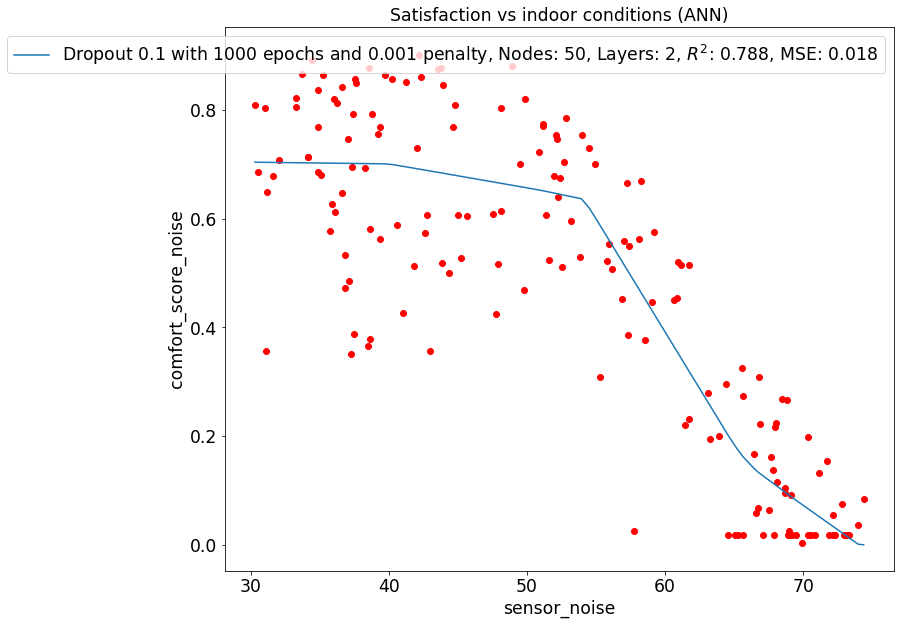

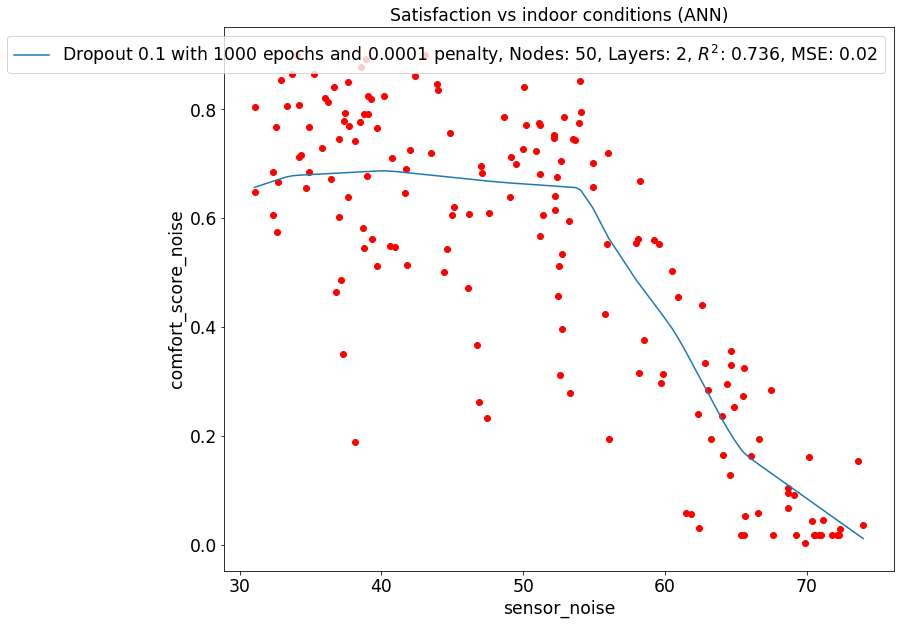

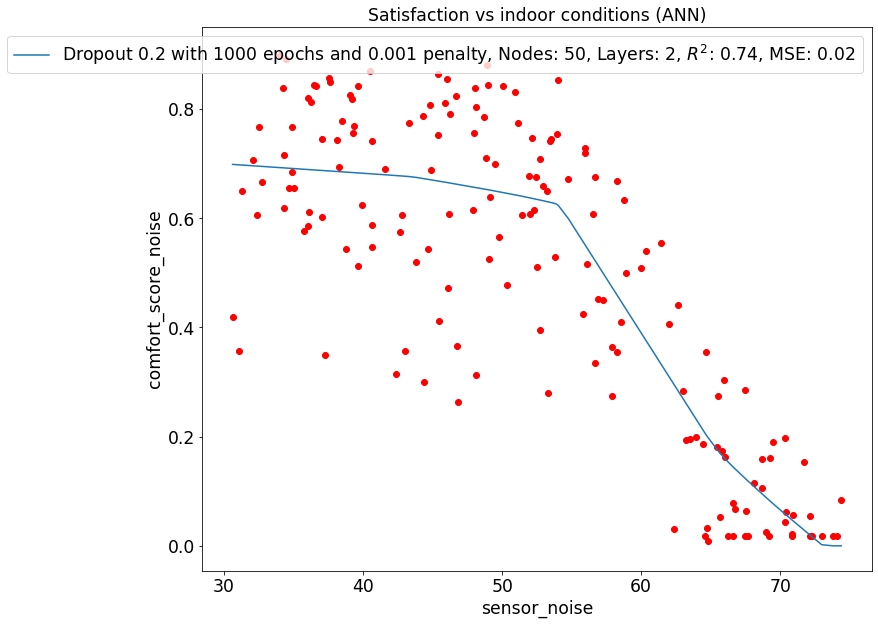

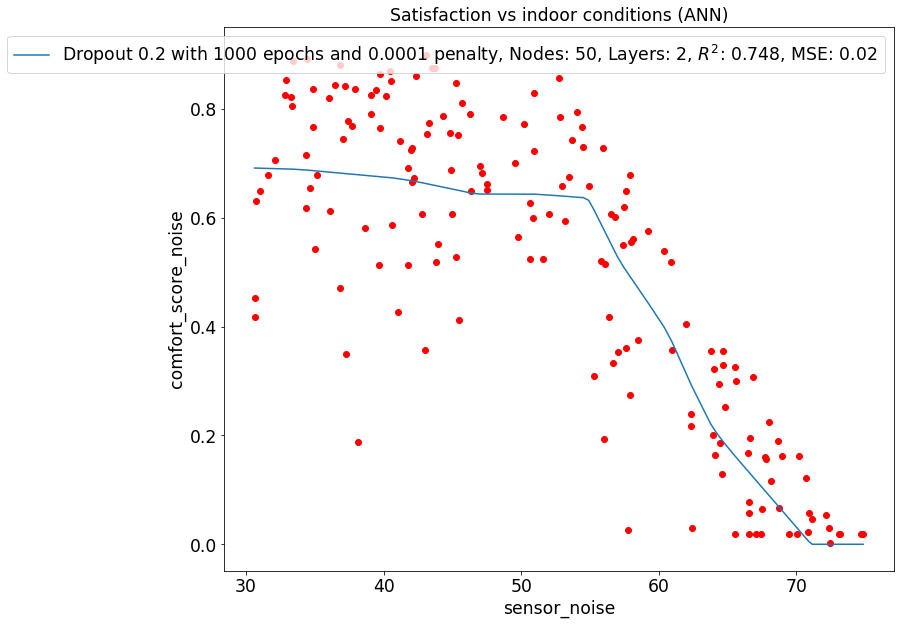

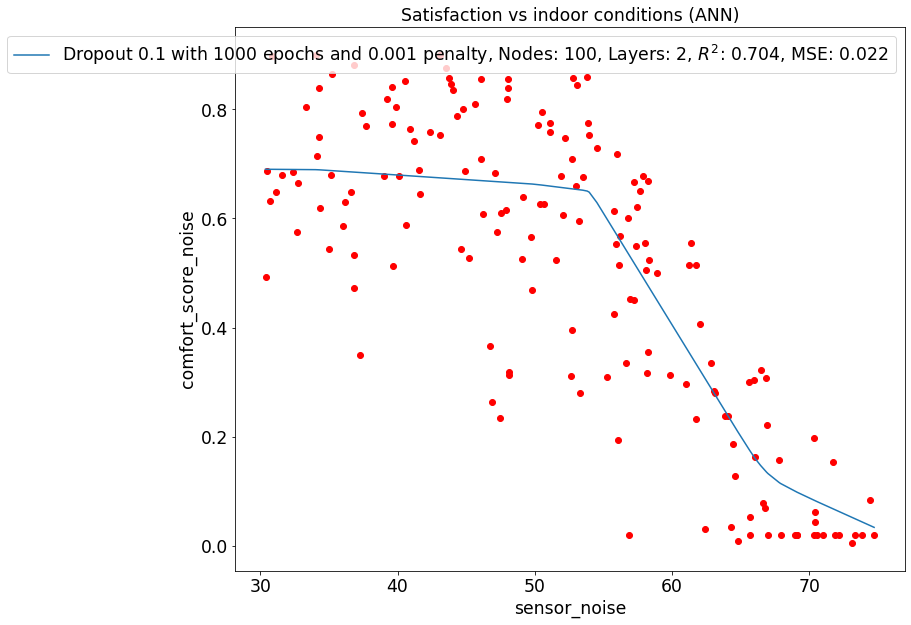

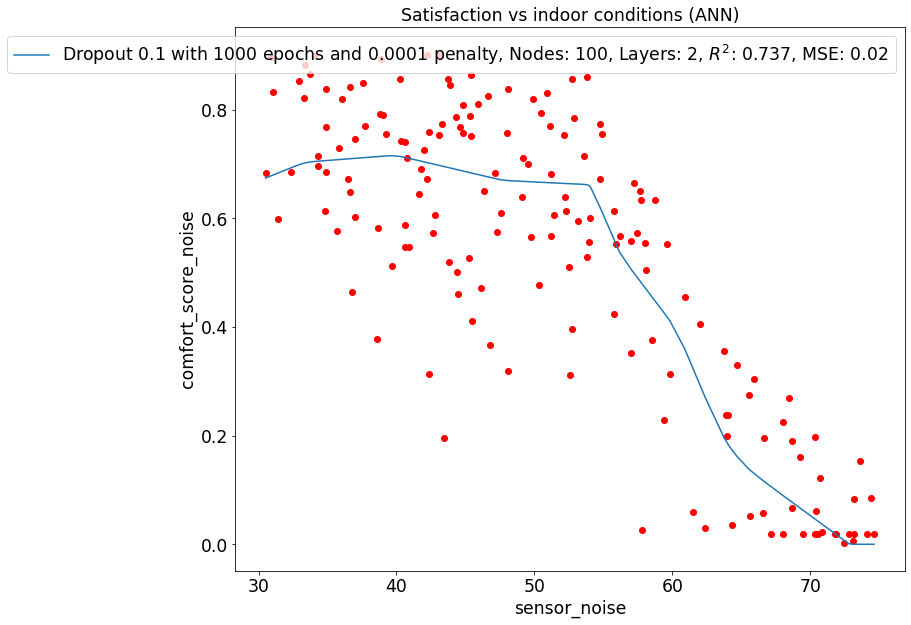

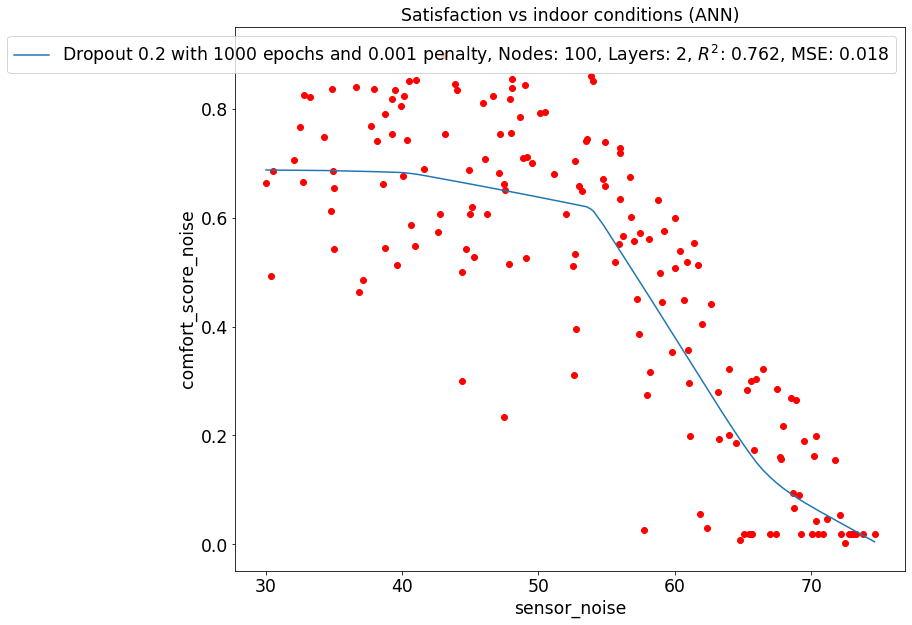

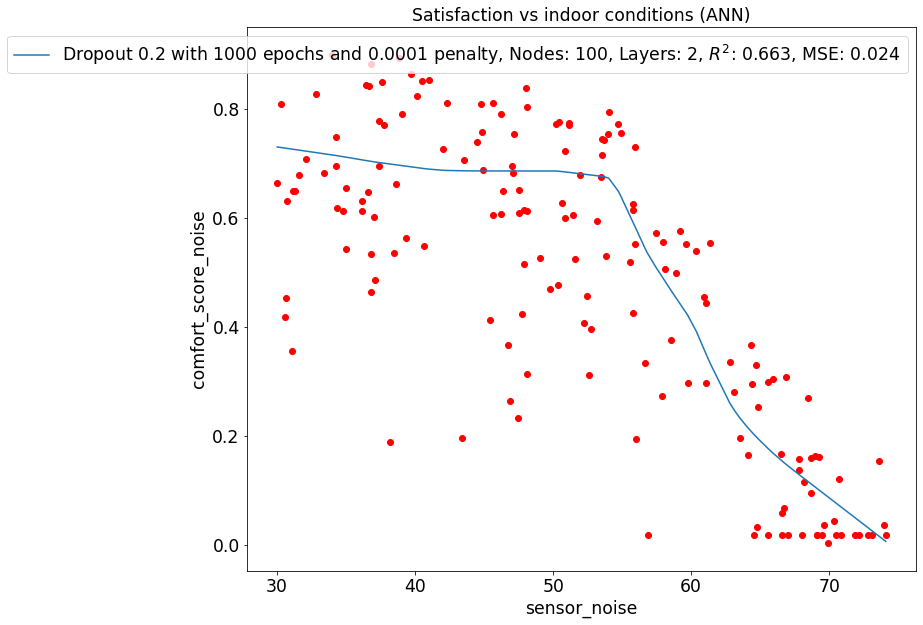

In [249]:
# Chose the number of neurons and number of hidden layers and a dropout rate

number_of_nodes = [50, 100]
number_of_layers = [2]
dropout_rate = [0.1, 0.2]
number_of_epochs = [1000]
regularization_penalty = [0.001, 0.0001]
Results_ANN_list = []

# Fit ANN model

plt.figure(figsize=(12, 10))

for nodes in tqdm_notebook(number_of_nodes):
    for layers in tqdm_notebook(number_of_layers):
        for dropout in tqdm_notebook(dropout_rate):
            for epochs in tqdm_notebook(number_of_epochs):
                for regularization in tqdm_notebook(regularization_penalty):
                    R2_ANN, MSE_ANN, training_history = ANN(X, y, nodes, layers, dropout, epochs, regularization,
                                                            'plot', sensor_name, score_name)
                    Results_ANN_list.append([nodes, layers, dropout, epochs, regularization, R2_ANN, MSE_ANN])

#### Display the results for ANN

In [250]:
Results_ANN = pd.DataFrame(Results_ANN_list, columns=['Number of nodes', 'Number of layers', 'Dropout rate',
                                                      'Number of epochs', 'Regularization penalty', 'R2_ANN',
                                                      'MSE_ANN'])
Results_ANN.sort_values(['R2_ANN'], ascending = False)

,Number of nodes,Number of layers,Dropout rate,Number of epochs,Regularization penalty,R2_ANN,MSE_ANN
0,50,2,0.1,1000,0.0010,0.787698,0.018076
6,100,2,0.2,1000,0.0010,0.762323,0.018255
3,50,2,0.2,1000,0.0001,0.747708,0.019586
2,50,2,0.2,1000,0.0010,0.739790,0.020399
5,100,2,0.1,1000,0.0001,0.737363,0.020256
1,50,2,0.1,1000,0.0001,0.736098,0.020144
4,100,2,0.1,1000,0.0010,0.704471,0.022227
7,100,2,0.2,1000,0.0001,0.663164,0.024367


## Regression
This method takes as parameter the degree: **degree**, of the polynomial function to be fitted.

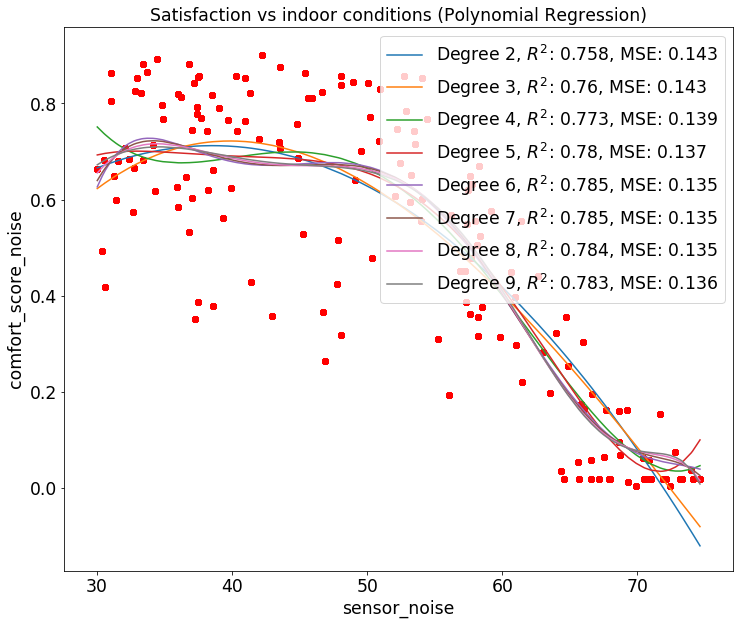

In [238]:
# Evaluate performance of regression models over different degrees

degree_range_regression = 10

Results_regression = []

plt.figure(figsize=(12, 10))
for degree in range(2, degree_range_regression):
    R2_regression, MSE_regression = Regression(X, y, sensor_name, score_name, degree,
                                               'plot')
    Results_regression.append([degree, R2_regression, MSE_regression])

#### Display the results for Regression

In [239]:
Results_regression = pd.DataFrame(Results_regression, columns=['degree', 'R2_regression', 'MSE_regression'])

Results_regression.sort_values(['R2_regression'], ascending = False)

,degree,R2_regression,MSE_regression
4,6,0.785375,0.135099
5,7,0.785027,0.135208
6,8,0.784231,0.135458
7,9,0.783103,0.135812
3,5,0.779545,0.136921
2,4,0.772526,0.139084
1,3,0.760140,0.142820
0,2,0.758018,0.143451


## Spline Regression
This method takes as parameter the degree: **degree**, of the polynomial function to be fitted and points of division of the series: **quantiles**.

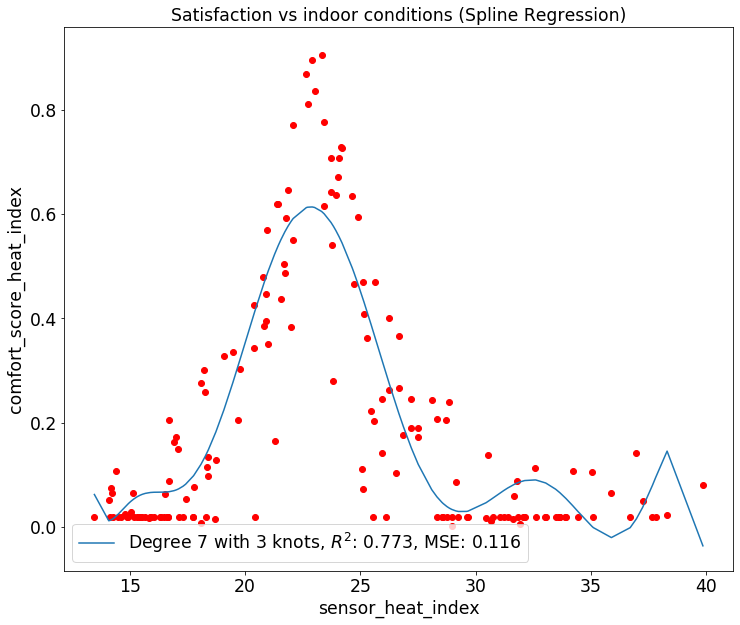

In [273]:
degree_range_spline = 9
quantiles_in_spline_regression = (0.25, 0.5, 0.75)

Results_splines = []

plt.figure(figsize=(12, 10))
for degree in range(2, degree_range_spline):
    R2_spline, MSE_spline = Spline_Regression(X, y, sensor_name, score_name, degree,
                                              quantiles_in_spline_regression, 'plot')
    Results_splines.append([degree, R2_spline, MSE_spline])

#### Display the results for Splines

In [270]:
Results_splines = pd.DataFrame(Results_splines, columns=['degree', 'R2_spline', 'MSE_spline'])

Results_splines.sort_values(['R2_spline'], ascending = False)

,degree,R2_spline,MSE_spline
6,8,0.801184,0.108196
7,9,0.796111,0.109567
4,6,0.780371,0.113718
5,7,0.772620,0.115707
1,3,0.761222,0.118571
3,5,0.760952,0.118639
2,4,0.749616,0.121419
0,2,0.678410,0.137605
